In [90]:
!pip install utils --quiet

In [91]:
!pip install imblearn --quiet


In [92]:
!pip install catboost --quiet

In [93]:
!pip install plotly --quiet

In [94]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Introduction:

Welcome to this data analysis project aimed at developing a robust model for predicting loan defaults. In this endeavor, we delve into the intricate landscape of loan applications, aiming to empower MoneyLion with sharper risk assessment tools.

Imagine a scenario where a prospective borrower submits a loan application. The process is set in motion, with meticulous scrutiny carried out by underwriters to detect any potential fraud. Once deemed legitimate, the application progresses to approval, culminating in the funding of the loan.

Our mission is clear: to position our predictive model strategically between the stages of fraud detection and loan approval. By doing so, we aim to provide a crucial checkpoint, offering a nuanced evaluation of risk that complements existing processes. We acknowledge the effectiveness of fraud detection mechanisms in sieving out most fraudulent applications, allowing us to focus our efforts on risk assessment with precision and clarity.

Through this endeavor, we aspire to furnish lenders, such as MoneyLion, with a discerning tool capable of gauging the risk associated with each application. This, in turn, facilitates well-informed business decisions, aligning with the company's risk tolerance and fostering a culture of prudent lending practices. Join us as we navigate through data, algorithms, and insights, charting a course toward enhanced risk management in the realm of lending.



# Libraries

In [96]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pprint import pprint
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.max_columns = None
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid', palette='pastel')
from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import plotly.graph_objects as go
import plotly.express as px
from utils import *

# Exploratory Data Analysis (EDA)


In [97]:
loan = pd.read_csv('/content/drive/MyDrive/loan-default-model/loan.csv', parse_dates=['applicationDate', 'originatedDate'])

loan.head()

loanId                          anon_ssn payFrequency    apr  \
0  LL-I-07399092  beff4989be82aab4a5b47679216942fd            B  360.0   
1  LL-I-06644937  464f5d9ae4fa09ece4048d949191865c            B  199.0   
2  LL-I-10707532  3c174ae9e2505a5f9ddbff9843281845            B  590.0   
3  LL-I-02272596  9be6f443bb97db7e95fa0c281d34da91            B  360.0   
4  LL-I-09542882  63b5494f60b5c19c827c7b068443752c            B  590.0   

          applicationDate  originated          originatedDate  nPaidOff  \
0 2016-02-23 17:29:01.940       False                     NaT       0.0   
1 2016-01-19 22:07:36.778        True 2016-01-20 15:49:18.846       0.0   
2 2016-08-01 13:51:14.709       False                     NaT       0.0   
3 2015-08-06 23:58:08.880       False                     NaT       0.0   
4 2016-06-05 22:31:34.304       False                     NaT       0.0   

   approved  isFunded             loanStatus  loanAmount  \
0     False         0  Withdrawn Application       500.0   
1      True         1          Paid Off Loan      3000.0   
2     False         0  Withdrawn Application       400.0   
3     False         0  Withdrawn Application       500.0   
4     False         0               Rejected       350.0   

   originallyScheduledPaymentAmount state     leadType  leadCost fpStatus  \
0                            978.27    IL  bvMandatory         6      NaN   
1                           6395.19    CA    prescreen         0  Checked   
2                           1199.45    MO  bvMandatory         3      NaN   
3                           1074.05    IL  bvMandatory         3      NaN   
4                            814.37    NV  bvMandatory         3      NaN   

             clarityFraudId  hasCF  
0  5669ef78e4b0c9d3936440e6      1  
1  569eb3a3e4b096699f685d64      1  
2  579eab11e4b0d0502870ef2f      1  
3  555b1e95e4b0f6f11b267c18      1  
4  5754a91be4b0c6a2bf424772      1

In [98]:
pprint(loan.columns)

Index(['loanId', 'anon_ssn', 'payFrequency', 'apr', 'applicationDate',
       'originated', 'originatedDate', 'nPaidOff', 'approved', 'isFunded',
       'loanStatus', 'loanAmount', 'originallyScheduledPaymentAmount', 'state',
       'leadType', 'leadCost', 'fpStatus', 'clarityFraudId', 'hasCF'],
      dtype='object')


In [99]:
loan.describe()

apr       nPaidOff       isFunded     loanAmount  \
count  573760.000000  577658.000000  577682.000000  575432.000000   
mean      553.080972       0.037887       0.067480     514.245084   
std       110.046159       0.333366       0.250852     320.939929   
min         0.000000       0.000000       0.000000       0.000000   
25%       490.000000       0.000000       0.000000     350.000000   
50%       590.000000       0.000000       0.000000     500.000000   
75%       601.000000       0.000000       0.000000     500.000000   
max       705.590000      21.000000       1.000000    5000.000000   

       originallyScheduledPaymentAmount       leadCost          hasCF  
count                     577682.000000  577682.000000  577682.000000  
mean                        1428.897209       7.854389       0.619187  
std                          925.009141      12.853451       0.485587  
min                         -816.710000       0.000000       0.000000  
25%                         1023.640000       3.000000       0.000000  
50%                         1245.250000       3.000000       1.000000  
75%                         1615.660000       6.000000       1.000000  
max                        19963.630000     200.000000       1.000000

#Why payments data shouldn't be used in predicting Loan should be disbursed or not?

1. If the payments.csv contains information about the payments made after the loan was granted, including it in your prediction model could lead to data leakage. This is because you would be using information not available at the time of loan application to predict its outcome, which would make your model unrealistic and overly optimistic.

2. The payments data might not be temporally relevant to the prediction you are making. If your model aims to predict the likelihood of a loan being approved or its risk of default at the time of application, then payment history, which is future-oriented, would not be applicable.

3. The scope of your model might be to predict initial loan approval, not the subsequent payment performance of the borrower. Including payments data would shift the focus of the model to post-approval events.

4. Payment data can be sensitive, as it may include detailed financial transactions. There could be privacy or regulatory reasons why this information should not be used in a predictive model.

In summary, while payments data can be rich in insights for certain types of models, it might not be appropriate for a loan prediction model aimed at assessing the risk or approval at the application stage.









In [100]:
underwriting_var = pd.read_csv('/content/drive/MyDrive/loan-default-model/clarity_underwriting_variables.csv', low_memory=False)

underwriting_var.head()

.underwritingdataclarity.clearfraud.clearfraudinquiry.thirtydaysago  \
0                                                8.0                     
1                                                5.0                     
2                                                9.0                     
3                                                3.0                     
4                                                5.0                     

   .underwritingdataclarity.clearfraud.clearfraudinquiry.twentyfourhoursago  \
0                                                2.0                          
1                                                2.0                          
2                                                4.0                          
3                                                2.0                          
4                                                5.0                          

   .underwritingdataclarity.clearfraud.clearfraudinquiry.oneminuteago  \
0                                                2.0                    
1                                                2.0                    
2                                                2.0                    
3                                                2.0                    
4                                                2.0                    

   .underwritingdataclarity.clearfraud.clearfraudinquiry.onehourago  \
0                                                2.0                  
1                                                2.0                  
2                                                3.0                  
3                                                2.0                  
4                                                2.0                  

   .underwritingdataclarity.clearfraud.clearfraudinquiry.ninetydaysago  \
0                                                8.0                     
1                                               11.0                     
2                                               10.0                     
3                                                9.0                     
4                                                6.0                     

   .underwritingdataclarity.clearfraud.clearfraudinquiry.sevendaysago  \
0                                                2.0                    
1                                                2.0                    
2                                                8.0                    
3                                                2.0                    
4                                                5.0                    

   .underwritingdataclarity.clearfraud.clearfraudinquiry.tenminutesago  \
0                                                2.0                     
1                                                2.0                     
2                                                2.0                     
3                                                2.0                     
4                                                2.0                     

   .underwritingdataclarity.clearfraud.clearfraudinquiry.fifteendaysago  \
0                                                5.0                      
1                                                4.0                      
2                                                9.0                      
3                                                2.0                      
4                                                5.0                      

   .underwritingdataclarity.clearfraud.clearfraudinquiry.threesixtyfivedaysago  \
0                                               10.0                             
1                                               21.0                             
2                                               25.0                             
3                                                9.0                             
4                          

In [101]:
underwriting_var.describe()

.underwritingdataclarity.clearfraud.clearfraudinquiry.thirtydaysago  \
count                                       49750.000000                     
mean                                            7.313628                     
std                                             6.327122                     
min                                             0.000000                     
25%                                             3.000000                     
50%                                             5.000000                     
75%                                             9.000000                     
max                                            89.000000                     

       .underwritingdataclarity.clearfraud.clearfraudinquiry.twentyfourhoursago  \
count                                       49750.000000                          
mean                                            4.601990                          
std                                             3.302288                          
min                                             0.000000                          
25%                                             3.000000                          
50%                                             3.000000                          
75%                                             5.000000                          
max                                            60.000000                          

       .underwritingdataclarity.clearfraud.clearfraudinquiry.oneminuteago  \
count                                       49750.000000                    
mean                                            2.343980                    
std                                             1.436345                    
min                                             0.000000                    
25%                                             1.000000                    
50%                                             3.000000                    
75%                                             3.000000                    
max                                            16.000000                    

       .underwritingdataclarity.clearfraud.clearfraudinquiry.onehourago  \
count                                       49750.000000                  
mean                                            4.006874                  
std                                             2.697831                  
min                                             0.000000                  
25%                                             3.000000                  
50%                                             3.000000                  
75%                                             5.000000                  
max                                            42.000000                  

       .underwritingdataclarity.clearfraud.clearfraudinquiry.ninetydaysago  \
count                                       49750.000000                     
mean                                           10.554513                     
std                                            10.450845                     
min                                             0.000000                     
25%                                             4.000000                     
50%                                             7.000000                     
75%                                            13.000000                     
max                                           202.000000                     

       .underwritingdataclarity.clearfraud.clearfraudinquiry.sevendaysago  \
count                                       49750.000000                    
mean                                            5.423799                    
std                                             4.110483                    
min                                             0.000000                    
25%                                             3.000000                    
50%                  

Join & merge the two dataframes along the appropriate ID column, and filter by funded loans.

In [102]:
df = loan.merge(underwriting_var, left_on='clarityFraudId', right_on='underwritingid', how='left')
df = df[df['isFunded'] == 1]
df.head()

loanId                          anon_ssn payFrequency    apr  \
1   LL-I-06644937  464f5d9ae4fa09ece4048d949191865c            B  199.0   
15  LL-I-12263369  accf40708233e8b7d05fcb89d5a9c081            B  475.0   
33  LL-I-17826953  7529d29c9d943cc55bc71a85d9c6b7a3            W  645.0   
47  LL-I-16519347  bc9fa73468acf18cb968a3a6a3c4697c            S  490.0   
54  LL-I-11506719  10cefd11d41612b032fd9cd2debe32dc            B  590.0   

           applicationDate  originated          originatedDate  nPaidOff  \
1  2016-01-19 22:07:36.778        True 2016-01-20 15:49:18.846       0.0   
15 2016-11-28 19:54:22.982        True 2016-11-29 20:30:40.640       2.0   
33 2017-03-01 15:55:41.823        True 2017-03-01 16:15:13.016       0.0   
47 2017-01-31 17:48:17.381        True 2017-01-31 18:00:14.520       2.0   
54 2016-08-27 09:08:05.442        True 2016-08-29 15:05:04.014       0.0   

    approved  isFunded     loanStatus  loanAmount  \
1       True         1  Paid Off Loan      3000.0   
15      True         1       New Loan       350.0   
33      True         1       New Loan       400.0   
47      True         1  Paid Off Loan      1250.0   
54      True         1  Paid Off Loan       800.0   

    originallyScheduledPaymentAmount state     leadType  leadCost fpStatus  \
1                            6395.19    CA    prescreen         0  Checked   
15                            893.88    MO      organic         0  Checked   
33                           1364.87    NJ         lead        40  Checked   
47                           3313.78    MO      organic         0  Checked   
54                           2432.08    CA  bvMandatory        10  Checked   

              clarityFraudId  hasCF  \
1   569eb3a3e4b096699f685d64      1   
15                       NaN      0   
33  58b6eef8e4b0b6fca82fd426      1   
47  58450a15e4b0bb9d6d7344c7      1   
54  578f9346e4b0810ad5e7b72e      1   

    .underwritingdataclarity.clearfraud.clearfraudinquiry.thirtydaysago  \
1                                                 3.0                     
15                                                NaN                     
33                                                3.0                     
47                                                4.0                     
54                                               13.0                     

    .underwritingdataclarity.clearfraud.clearfraudinquiry.twentyfourhoursago  \
1                                                 3.0                          
15                                                NaN                          
33                                                3.0                          
47                                                4.0                          
54                                                3.0                          

    .underwritingdataclarity.clearfraud.clearfraudinquiry.oneminuteago  \
1                                                 3.0                    
15                                                NaN                    
33                                                3.0                    
47                                                1.0                    
54                                                3.0                    

    .underwritingdataclarity.clearfraud.clearfraudinquiry.onehourago  \
1                                                 3.0                  
15                                                NaN                  
33                                                3.0                  
47                                                4.0                  
54                                                3.0                  

    .underwritingdataclarity.clearfraud.clearfraudinquiry.ninetydaysago  \
1                                                 3.0                     
15                                                NaN                     
33                                           

Then, for brevity, we drop all columns that initially appear to hold no meaningful information. This includes most features from clarity_underwriting_variables.csv, since :
1. our model is primarily tasked with risk assessment, not fraud detection
2. we'll assume that clearfraudscore sufficiently summarizes the findings of the underwriting team.

In [103]:
# Print clearfraudscore description
underwriting_var_columns = pd.read_csv('/content/drive/MyDrive/loan-default-model/clarity_underwriting_dictionary.csv')
cfs_desc = underwriting_var_columns[underwriting_var_columns['fieldName_in_file'] == 'clearFraudScore']['Description'].values[0]
print(f'Clear Fraud Score: {cfs_desc}.')

Clear Fraud Score: fraud score provided by clarity. Higher score suggests lower default probability.


In [104]:
# Drop irrelevant columns
df = df[['loanId',
         'anon_ssn',
         'payFrequency',
         'apr',
         'applicationDate',
         'originatedDate',
         'nPaidOff',
         'loanStatus',
         'loanAmount',
         'originallyScheduledPaymentAmount',
         'state',
         'leadType',
         'leadCost',
         'fpStatus',
         'hasCF',
         'clearfraudscore']]
# Display results
df.head()

loanId                          anon_ssn payFrequency    apr  \
1   LL-I-06644937  464f5d9ae4fa09ece4048d949191865c            B  199.0   
15  LL-I-12263369  accf40708233e8b7d05fcb89d5a9c081            B  475.0   
33  LL-I-17826953  7529d29c9d943cc55bc71a85d9c6b7a3            W  645.0   
47  LL-I-16519347  bc9fa73468acf18cb968a3a6a3c4697c            S  490.0   
54  LL-I-11506719  10cefd11d41612b032fd9cd2debe32dc            B  590.0   

           applicationDate          originatedDate  nPaidOff     loanStatus  \
1  2016-01-19 22:07:36.778 2016-01-20 15:49:18.846       0.0  Paid Off Loan   
15 2016-11-28 19:54:22.982 2016-11-29 20:30:40.640       2.0       New Loan   
33 2017-03-01 15:55:41.823 2017-03-01 16:15:13.016       0.0       New Loan   
47 2017-01-31 17:48:17.381 2017-01-31 18:00:14.520       2.0  Paid Off Loan   
54 2016-08-27 09:08:05.442 2016-08-29 15:05:04.014       0.0  Paid Off Loan   

    loanAmount  originallyScheduledPaymentAmount state     leadType  leadCost  \
1       3000.0                           6395.19    CA    prescreen         0   
15       350.0                            893.88    MO      organic         0   
33       400.0                           1364.87    NJ         lead        40   
47      1250.0                           3313.78    MO      organic         0   
54       800.0                           2432.08    CA  bvMandatory        10   

   fpStatus  hasCF  clearfraudscore  
1   Checked      1            879.0  
15  Checked      0              NaN  
33  Checked      1            658.0  
47  Checked      1            835.0  
54  Checked      1            624.0

# Data Visualization and Exploration

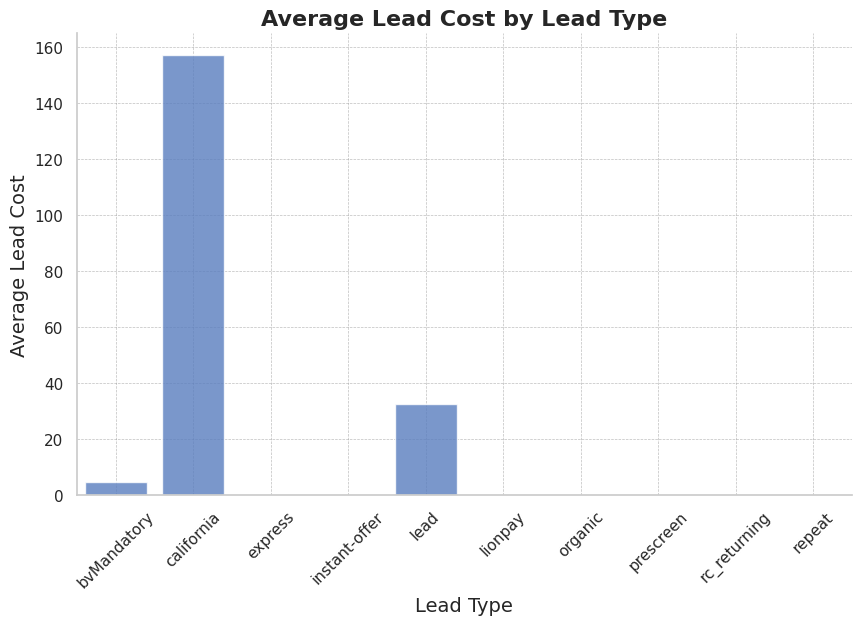

In [105]:
# @title Lead Cost by Lead Type


sns.set_style("whitegrid")
sns.set_palette("muted")


plt.figure(figsize=(10, 6))
average_lead_cost = df.groupby('leadType')['leadCost'].mean()
sns.barplot(x=average_lead_cost.index, y=average_lead_cost.values, alpha=0.8)


plt.title('Average Lead Cost by Lead Type', fontsize=16, fontweight='bold')
plt.xlabel('Lead Type', fontsize=14)
plt.ylabel('Average Lead Cost', fontsize=14)
plt.xticks(rotation=45)


plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


plt.grid(True, which="major", linestyle='--', linewidth=0.5, color='grey', alpha=0.5)

# Show the plot
plt.show()


 1. There is a significant variation in lead costs across different types. 'California' leads stand out as having a particularly high average cost compared to other categories.

 2. Depending on the conversion rate of these leads to actual customers or the revenue generated, this chart could highlight which lead types are more cost-effective.

3. This could inform where a Money Lion might want to allocate or reduce spending in their marketing budget.

4. If certain lead types with lower costs have a reasonable conversion rate, it might make sense to focus on these areas.

In terms of the implications for loan origination and risk analysis:

Higher Cost and Risk: More expensive leads like 'California' might be associated with a higher customer lifetime value or might carry a higher risk, requiring more careful underwriting.

Lower Cost and Conversion: If less expensive lead types like 'lionpay' or 'prescreen' have a decent conversion rate, they might represent a more efficient acquisition strategy.

Lead Type and Loan Performance: There might be a correlation between the type of lead and the performance of the loan. For example, 'organic' leads might show a different risk profile compared to 'prescreen' leads.

**This kind of analysis is critical for understanding the efficiency of marketing expenditures in loan origination and can also be a factor in assessing the potential risk associated with different lead sources.**

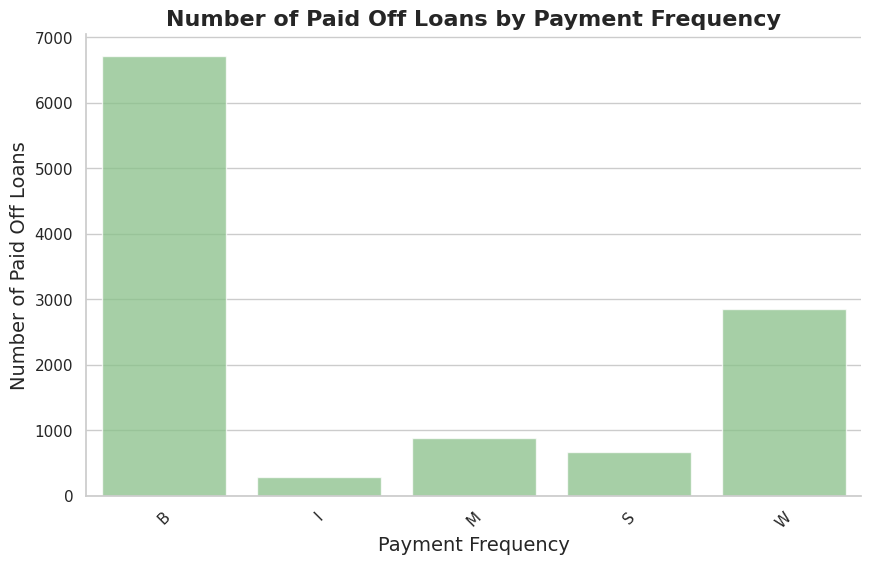

In [106]:
# @title Paid Off Loans by Payment Frequency


sns.set_style("whitegrid")
sns.set_palette("Accent")


paid_off_loans_by_freq = df[df['loanStatus'] == 'Paid Off Loan'].groupby('payFrequency')['loanId'].count()


plt.figure(figsize=(10, 6))
sns.barplot(x=paid_off_loans_by_freq.index, y=paid_off_loans_by_freq.values, alpha=0.75)


plt.title('Number of Paid Off Loans by Payment Frequency', fontsize=16, fontweight='bold')
plt.xlabel('Payment Frequency', fontsize=14)
plt.ylabel('Number of Paid Off Loans', fontsize=14)
plt.xticks(rotation=45)


plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


plt.show()


1. It may indicate common payment behaviors among borrowers. For example, bi-weekly payments might align better with many customers' payday schedules, leading to a higher rate of successful loan payoff.

2. The chart could inform risk assessment models. A higher rate of payoffs in certain payment frequency categories might suggest lower risk, which could impact the terms of the loan or approval decisions.

3. It might inform the Money Lion about the most popular or successful repayment plans, potentially guiding product offerings or marketing strategies.

For a loan fraud model, these insights could contribute to feature engineering or segmentation analysis. Payment frequency with its relation to loan payoff success could be an important feature, possibly impacting the probability of a loan being fraudulent or at risk of default. Understanding the patterns in repayment can help identify normal behavior, against which suspicious or anomalous behavior can be detected.

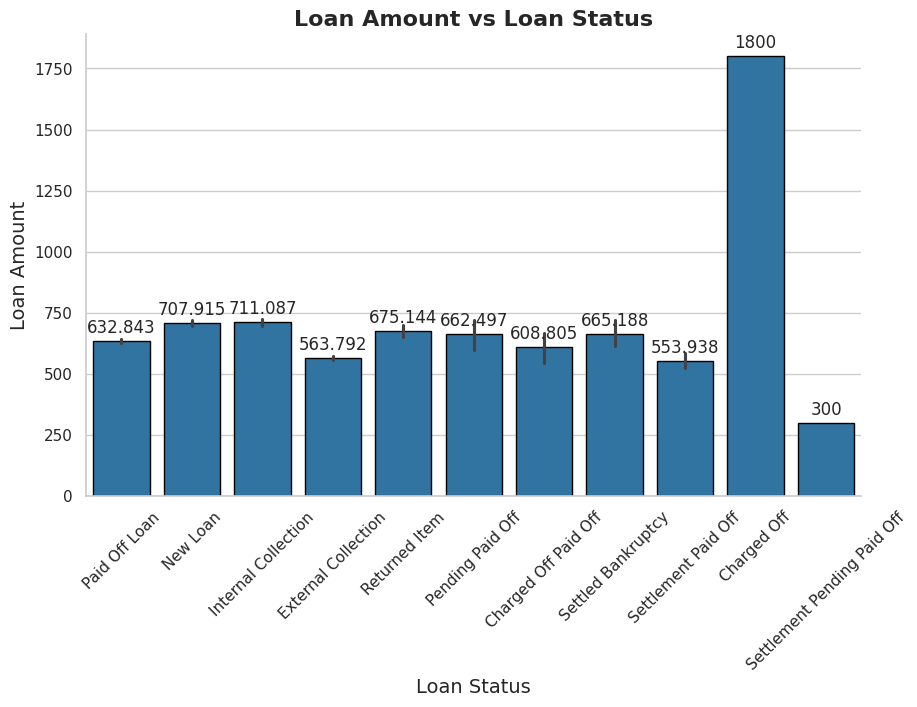

In [107]:
# @title Loan Amount vs Loan Status


sns.set_style("whitegrid")
sns.set_palette("tab10")


plt.figure(figsize=(10, 6))
sns.barplot(x="loanStatus", y="loanAmount", data=df, edgecolor='black')


plt.title('Loan Amount vs Loan Status', fontsize=16, fontweight='bold')
plt.xlabel('Loan Status', fontsize=14)
plt.ylabel('Loan Amount', fontsize=14)
plt.xticks(rotation=45)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


plt.bar_label(plt.gca().containers[0], label_type='edge', padding=3)


plt.show()


we can see that 'Settlement Paid Off' has the highest average loan amount, which may indicate larger loans are more likely to end in a settlement rather than full repayment. Conversely, the status 'Charged Off Pending Payment' has the lowest average loan amount, potentially suggesting that smaller loans are more often left unpaid.

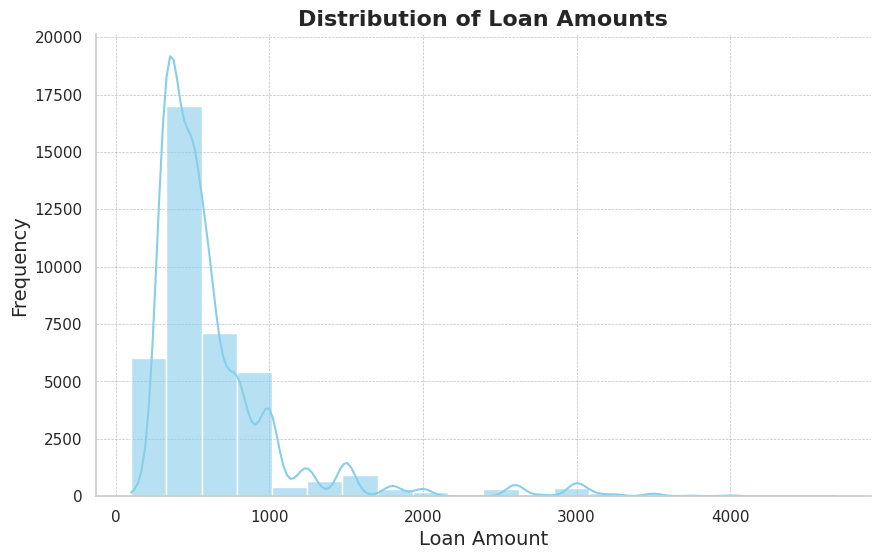

In [108]:
# @title loanAmount

sns.set_style("whitegrid")
sns.set_palette("pastel")


plt.figure(figsize=(10, 6))
sns.histplot(df['loanAmount'], bins=20, kde=True, color="skyblue", alpha=0.6)


plt.title('Distribution of Loan Amounts', fontsize=16, fontweight='bold')
plt.xlabel('Loan Amount', fontsize=14)
plt.ylabel('Frequency', fontsize=14)


plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


plt.grid(True, which="both", linestyle='--', linewidth=0.5, color='grey', alpha=0.5)

plt.show()

1. The distribution seems to be right-skewed, meaning there are a large number of loans with smaller amounts and fewer loans as the amount increases. This is typical for loan distributions, as smaller loans are more commonly taken out and approved.

2. The peak of the histogram occurs in the lower range of loan amounts, indicating that most borrowers take out smaller loans.
For building a loan fraud model, here are a few considerations:

3. The loan amount is a crucial variable as it may impact the likelihood of fraud. Typically, higher loan amounts could be subjected to more rigorous underwriting processes.

4. Given the skewness of the distribution, it might be beneficial to transform this variable before using it in the model to achieve a more normal distribution, which is assumed by many statistical modeling techniques.


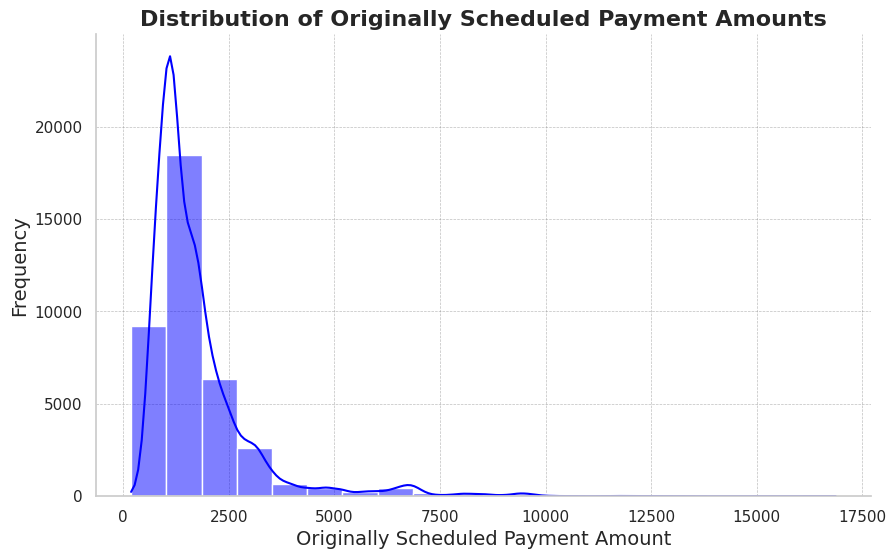

In [109]:
# @title originallyScheduledPaymentAmount


sns.set_style("whitegrid")
sns.set_palette("pastel")


plt.figure(figsize=(10, 6))
sns.histplot(df['originallyScheduledPaymentAmount'], bins=20, color="blue", kde=True, edgecolor="w")

# Customize the plot for better readability and visual appeal
plt.title('Distribution of Originally Scheduled Payment Amounts', fontsize=16, fontweight='bold')
plt.xlabel('Originally Scheduled Payment Amount', fontsize=14)
plt.ylabel('Frequency', fontsize=14)


plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


plt.grid(True, which="major", linestyle='--', linewidth=0.5, color='grey', alpha=0.5)


plt.show()


1. The distribution is right-skewed, indicating that there are a significant number of loans with lower scheduled payment amounts and fewer loans with higher scheduled payment amounts.

2. The highest peak (mode) of the distribution appears to be around the $2,500 mark, suggesting that this payment amount is the most common among the loans.

3. The spread of the distribution suggests that there is variability in the payment amounts, with a long tail extending towards the higher amounts. This indicates that while most loans have lower payment amounts, there are some loans with substantially higher payment amounts.

4. The smooth line provided by the KDE suggests the shape of the distribution if it were to be smoothed out, confirming the right-skewed nature of the distribution.

Implications for a loan_fraud model:

1. The originally scheduled payment amount could be an important feature for the loan_fraud model as it gives an indication of the loan size and the repayment capacity expected of the borrower.

2. Loans with very high scheduled payment amounts might be more scrutinized for fraud risk, as they could represent larger financial exposures.

3. Given the skewness of the distribution, it might be beneficial to apply a transformation to this feature when using it in a predictive model to ensure that the model is not unduly influenced by extreme values.

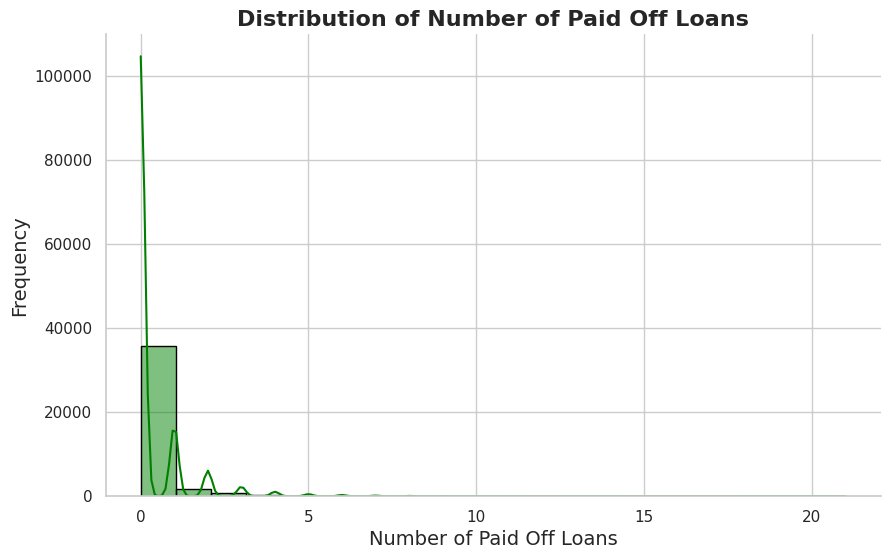

In [110]:
# @title nPaidOff


sns.set_style("whitegrid")
sns.set_palette("deep")


plt.figure(figsize=(10, 6))
sns.histplot(df['nPaidOff'], bins=20, color="green", kde=True, edgecolor="black")


plt.title('Distribution of Number of Paid Off Loans', fontsize=16, fontweight='bold')
plt.xlabel('Number of Paid Off Loans', fontsize=14)
plt.ylabel('Frequency', fontsize=14)


plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


plt.show()


1. The vast majority of clients in this dataset have paid off zero loans previously, suggesting a lot of new borrowers or one-time borrowers.

2. There is a rapidly diminishing frequency of clients as the number of previously paid-off loans increases.

3. Very few clients have paid off more than five loans.

4. The distribution seems to be right-skewed, meaning there are a large number of loans with smaller amounts and fewer loans as the amount increases.

This distribution could imply several things for a loan fraud model:

1. If the number of previously paid-off loans correlates with the likelihood of paying off future loans, this could be a significant feature in predicting loan default risk.

2. Given the skewness of the distribution, it might be beneficial to transform this variable before using it in the model to achieve a more normal distribution, which is assumed by many statistical modeling techniques.

3. The peak of the histogram occurs in the lower range of loan amounts, indicating that most borrowers take out smaller loans.
For building a loan fraud model, here are a few considerations:

4. The loan amount is a crucial variable as it may impact the likelihood of fraud. Typically, higher loan amounts could be subjected to more rigorous underwriting processes.



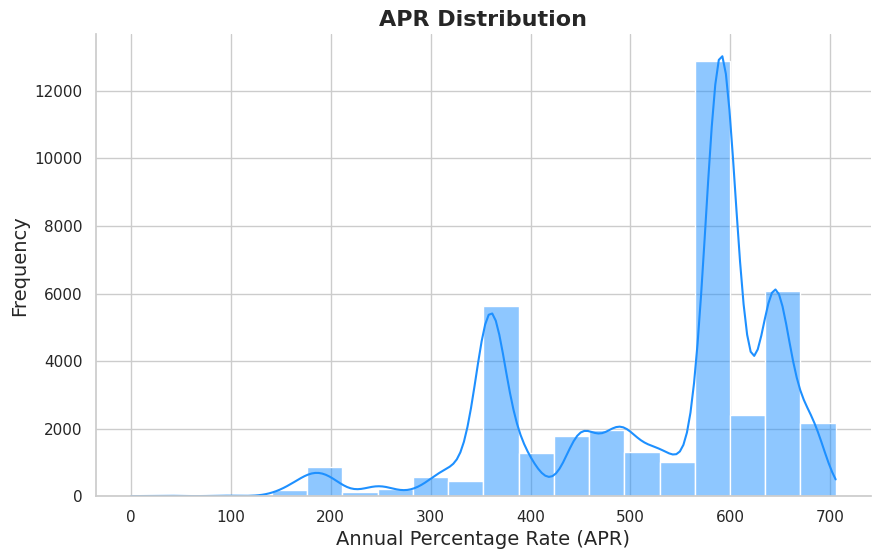

In [111]:
# @title apr

sns.set_style("whitegrid")
sns.set_palette("rocket")


plt.figure(figsize=(10, 6))
sns.histplot(df['apr'], bins=20, color="dodgerblue", kde=True, edgecolor="white")


plt.title('APR Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Annual Percentage Rate (APR)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)


plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


plt.show()



1. The plot shows a concentration of loans with an APR around the 100-200% range, which is significantly high. There are also substantial frequencies around 500-600%, which might indicate very high-cost loans, possibly for shorter terms or for customers with higher risk profiles.

2. This is a critical variable, as it represents the cost of borrowing. High APRs can be indicative of high-risk loans, which could be more prone to defaults.

3. If this data was present, it would indicate how many loans a customer has previously paid off and could be a good indicator of their creditworthiness.

4. For a loan fraud detection model, APR could be an essential feature, as unusually high or low APRs might indicate potential fraud or a high risk of default. If nPaidOff data were available, it would likely be a valuable predictor, as a history of paying off loans is a positive credit behavior.

5. The note on missing values is crucial; any missing data can skew analyses and model performance. For example, if APR data is missing for a significant number of loans, it may impact the model's ability to accurately assess the risk of loan default.


Given the plot and the information provided about the columns, the model would benefit from including features related to payment history, loan amount, loan cost, and the result of the first payment.

Interestingly all columns containing the financial terms of the loan are heavily skewed. Since these features are undoubtably important to the task at hand, we should either pick a model that's robust to skewness, or normalize these data during preprocessing.

Next, we tackle the features relating to time-components of the loan application, where if there are any noteworthy trends, we may consider extracting additional features from the data.

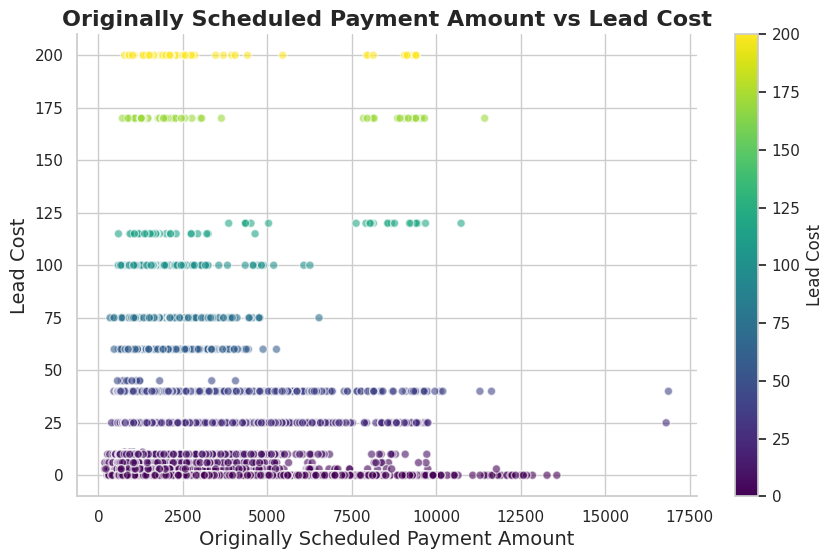

In [112]:

# @title originallyScheduledPaymentAmount vs leadCost

sns.set_style("whitegrid")


norm = plt.Normalize(df['leadCost'].min(), df['leadCost'].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])

plt.figure(figsize=(10, 6))
plt.scatter(df['originallyScheduledPaymentAmount'], df['leadCost'], c=df['leadCost'], cmap="viridis", alpha=0.6, edgecolor='w')


plt.title('Originally Scheduled Payment Amount vs Lead Cost', fontsize=16, fontweight='bold')
plt.xlabel('Originally Scheduled Payment Amount', fontsize=14)
plt.ylabel('Lead Cost', fontsize=14)
plt.colorbar(sm, label='Lead Cost')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


plt.show()


The bulk of the data points seem to cluster at the lower end of both the lead cost and payment amount axes, indicating that most loans have lower scheduled payment amounts and lower lead costs. However, there are some outliers with higher values in both, and some leads seem to have a high cost regardless of the scheduled payment amount.

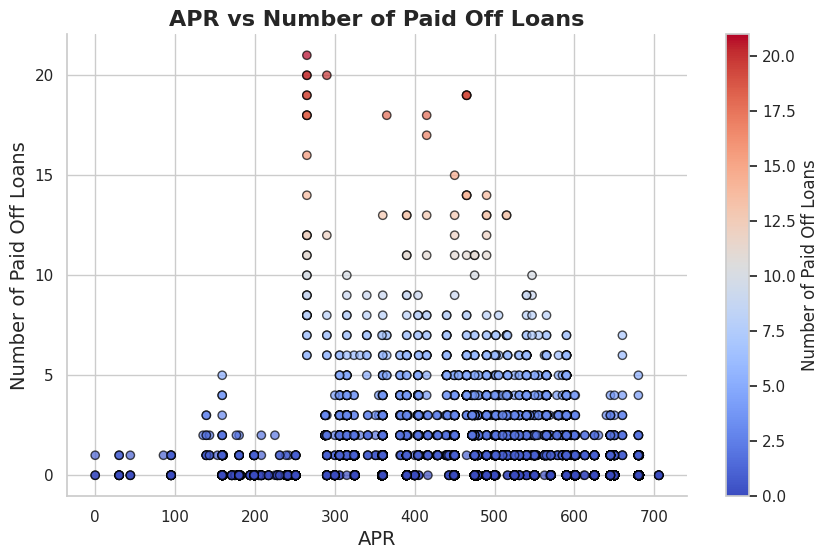

In [113]:
# @title apr vs nPaidOff


sns.set_style("whitegrid")


norm = plt.Normalize(df['nPaidOff'].min(), df['nPaidOff'].max())
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])


plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['apr'], df['nPaidOff'], c=df['nPaidOff'], cmap="coolwarm", alpha=0.7, edgecolor='black')


plt.title('APR vs Number of Paid Off Loans', fontsize=16, fontweight='bold')
plt.xlabel('APR', fontsize=14)
plt.ylabel('Number of Paid Off Loans', fontsize=14)
plt.colorbar(sm, label='Number of Paid Off Loans')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


plt.show()


1. The scatter plot shows that most of the data points are concentrated in the lower ranges of nPaidOff, particularly between 0 and 5. This suggests that the majority of clients have paid off only a few loans.

2. The apr values are spread across the range but seem to cluster in certain ranges, indicating that specific APR values are more common.

3. There are outliers present, particularly in the apr dimension, where some loans have exceptionally high APRs. These could be due to special loan conditions, potential data entry errors, or high-risk loans.

3. There doesn't appear to be a clear linear relationship between the APR and the number of loans paid off, which suggests that the APR may not be a direct predictor of the number of loans a client will pay off.

In the context of a loan fraud model:

1. The number of loans paid off (nPaidOff) could be an indicator of a client's repayment capability. Clients who have successfully paid off more loans might be considered lower risk.

2. Higher APRs could indicate higher risk loans. The scatter distribution could be analyzed further to understand if there's a certain APR threshold that correlates with a change in repayment behavior.

3. The plot might help in segmenting clients based on their loan repayment history and the APRs of their loans. Different segments might exhibit different risk profiles, which could be useful for a loan fraud model.

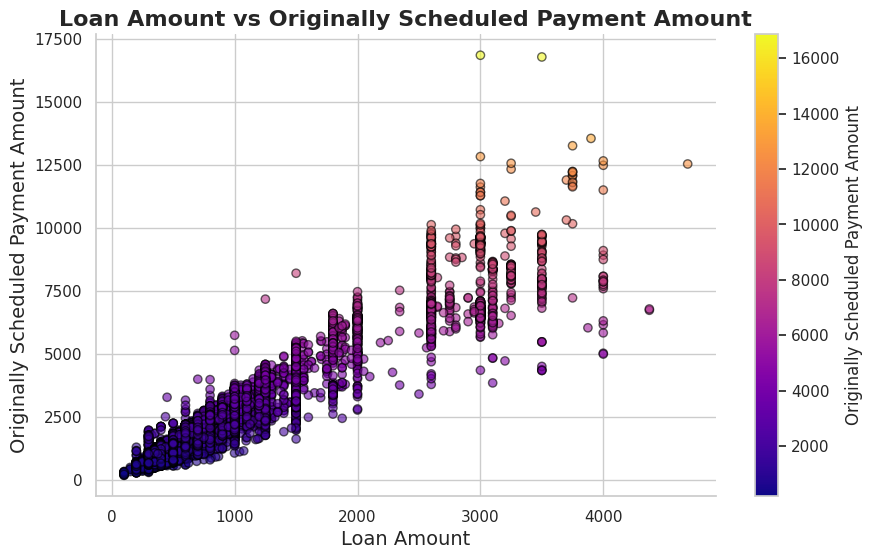

In [114]:
# @title Loan amount vs originally scheduled payment amount


sns.set_style("whitegrid")

norm = plt.Normalize(df['originallyScheduledPaymentAmount'].min(), df['originallyScheduledPaymentAmount'].max())
sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
sm.set_array([])


plt.figure(figsize=(10, 6))
plt.scatter(df['loanAmount'], df['originallyScheduledPaymentAmount'], c=df['originallyScheduledPaymentAmount'], cmap="plasma", alpha=0.6, edgecolor='black')

plt.title('Loan Amount vs Originally Scheduled Payment Amount', fontsize=16, fontweight='bold')
plt.xlabel('Loan Amount', fontsize=14)
plt.ylabel('Originally Scheduled Payment Amount', fontsize=14)
plt.colorbar(sm, label='Originally Scheduled Payment Amount')


plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


plt.show()


1. There appears to be a positive correlation between the loan amount and the originally scheduled payment amount. This makes sense as higher loan amounts would generally require larger repayment amounts due to interest and other fees.

2. The distribution is heavier on the lower end, indicating that a majority of the loans are of smaller amounts.


In the context of a loan fraud model:

1. The ratio of the total scheduled payment amount to the loan amount can indicate the cost of the loan to the borrower. Unusually high ratios might be scrutinized for predatory lending practices or incorrect data.

2. If the model detects that loans with certain characteristics (like extremely high repayment amounts relative to the loan amount) have a higher likelihood of default, it might weigh these factors more heavily.

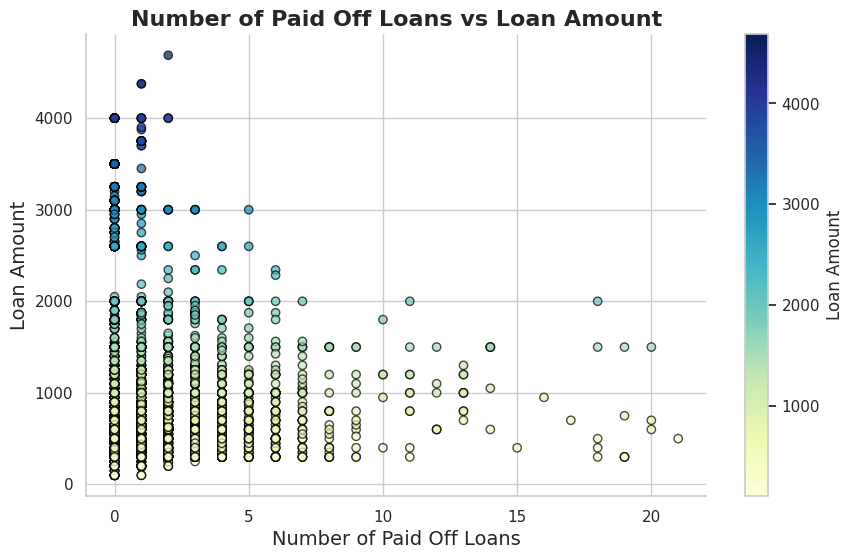

In [115]:
# @title nPaidOff vs loanAmount

sns.set_style("whitegrid")


norm = plt.Normalize(df['loanAmount'].min(), df['loanAmount'].max())
sm = plt.cm.ScalarMappable(cmap="YlGnBu", norm=norm)
sm.set_array([])

plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['nPaidOff'], df['loanAmount'], c=df['loanAmount'], cmap="YlGnBu", alpha=0.7, edgecolor='black')

plt.title('Number of Paid Off Loans vs Loan Amount', fontsize=16, fontweight='bold')
plt.xlabel('Number of Paid Off Loans', fontsize=14)
plt.ylabel('Loan Amount', fontsize=14)
plt.colorbar(sm, label='Loan Amount')


plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


plt.show()


1. The concentration of data points towards the bottom left corner of the plot suggests that most clients have a small number of paid-off loans with lower loan amounts.

2. There doesn't appear to be a strong trend or correlation between the number of loans paid off and the loan amount. Most clients with higher numbers of paid-off loans still fall into the lower to medium loan amount category.

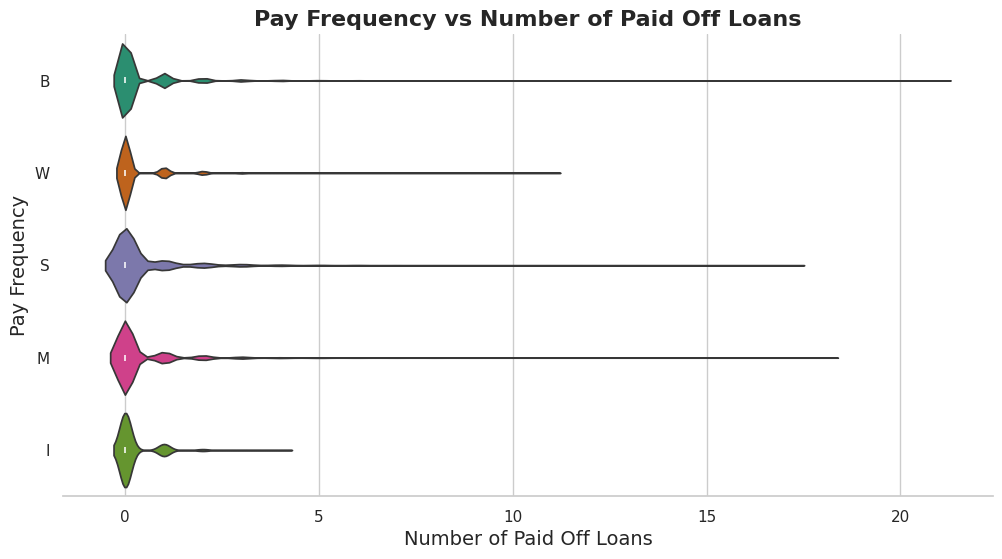

In [116]:
# @title payFrequency vs nPaidOff


sns.set_style("whitegrid")
sns.set_palette("Dark2")


figsize = (12, 1.2 * len(df['payFrequency'].unique()))

plt.figure(figsize=figsize)
sns.violinplot(data=df, x='nPaidOff', y='payFrequency', inner='box', scale='width', palette='Dark2')

plt.title('Pay Frequency vs Number of Paid Off Loans', fontsize=16, fontweight='bold')
plt.xlabel('Number of Paid Off Loans', fontsize=14)
plt.ylabel('Pay Frequency', fontsize=14)


sns.despine(top=True, right=True, left=True)


plt.show()

1. The width of each "violin" represents the density of data points at different counts of paid off loans. Wider sections indicate a higher frequency of borrowers with that specific number of paid off loans within the pay frequency category.

2. The thicker section of the violin indicates the concentration of data around a central value, which could suggest the most common number of loans paid off in each category. Thin sections indicate fewer customers with that number of paid off loans.

Implications for loan_fraud model:

1. Customers with regular pay frequencies (like weekly or biweekly) might have different financial behaviors compared to those with irregular pay frequencies, which could influence their loan repayment patterns and potentially their risk of fraud.

2. The number of previously paid off loans can be an indicator of creditworthiness and reliability. This feature can be highly relevant in predicting the likelihood of loan repayment and potential fraud.

These insights could be used for feature engineering. For example, the combination of pay frequency and the number of previously paid off loans could be a powerful feature in predicting loan repayment.

In the context of a loan_fraud model, this plot suggests that incorporating both the frequency of loan repayment and the historical number of paid-off loans could be significant predictors of loan repayment behavior and thus fraud risk. The variability in the number of paid-off loans across different pay frequencies may indicate differing financial management behaviors, which is valuable for risk assessment.

For instance, borrowers with a higher number of paid-off loans might be less likely to commit fraud, as they have a demonstrated history of fulfilling their loan obligations. In contrast, those with fewer or no paid-off loans might require more in-depth analysis to ascertain their risk levels.

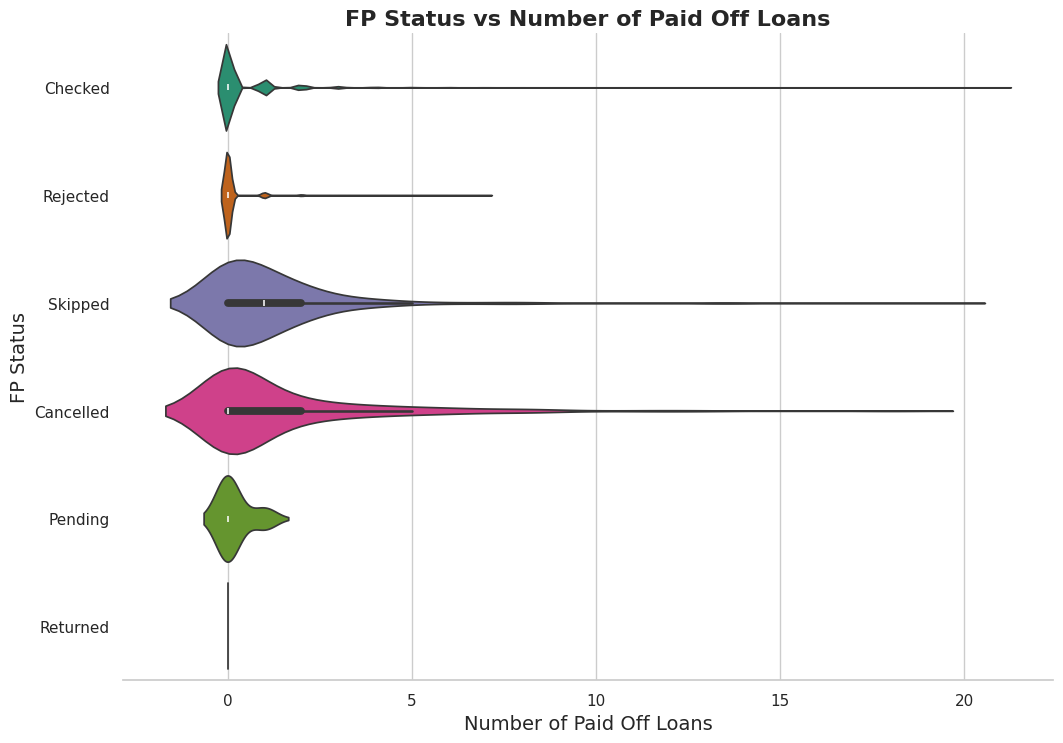

In [117]:
# @title fpStatus vs nPaidOff

sns.set_style("whitegrid")
sns.set_palette("Dark2")


figsize = (12, 1.2 * len(df['fpStatus'].unique()))

plt.figure(figsize=figsize)
sns.violinplot(data=df, x='nPaidOff', y='fpStatus', inner='box', scale='width', palette='Dark2')


plt.title('FP Status vs Number of Paid Off Loans', fontsize=16, fontweight='bold')
plt.xlabel('Number of Paid Off Loans', fontsize=14)
plt.ylabel('FP Status', fontsize=14)


sns.despine(top=True, right=True, left=True)


plt.show()


1. The "Checked" category likely represents loans where the first payment was made successfully. The width of the violin plot for this category might suggest that both new and returning clients who have varying numbers of previously paid-off loans fall into this category.

2. The "Rejected" category could indicate loans where the first payment attempt failed. This might be due to insufficient funds or other reasons. The distribution could give insights into whether clients who have a history of paying off loans still experience rejected payments.

3. Other categories like "Skipped", "Cancelled", "Pending", and "Returned" represent different statuses of the first payment. The distribution of nPaidOff within these categories could indicate whether certain payment behaviors are more common among clients with different levels of previous loan repayment history.

In the context of creating a loan fraud model, these distributions could be important. For example, if the "Rejected" category consistently shows a higher nPaidOff, it might suggest that despite a good history, certain customers are at risk of defaulting, which could be a signal of potential fraud or financial distress.

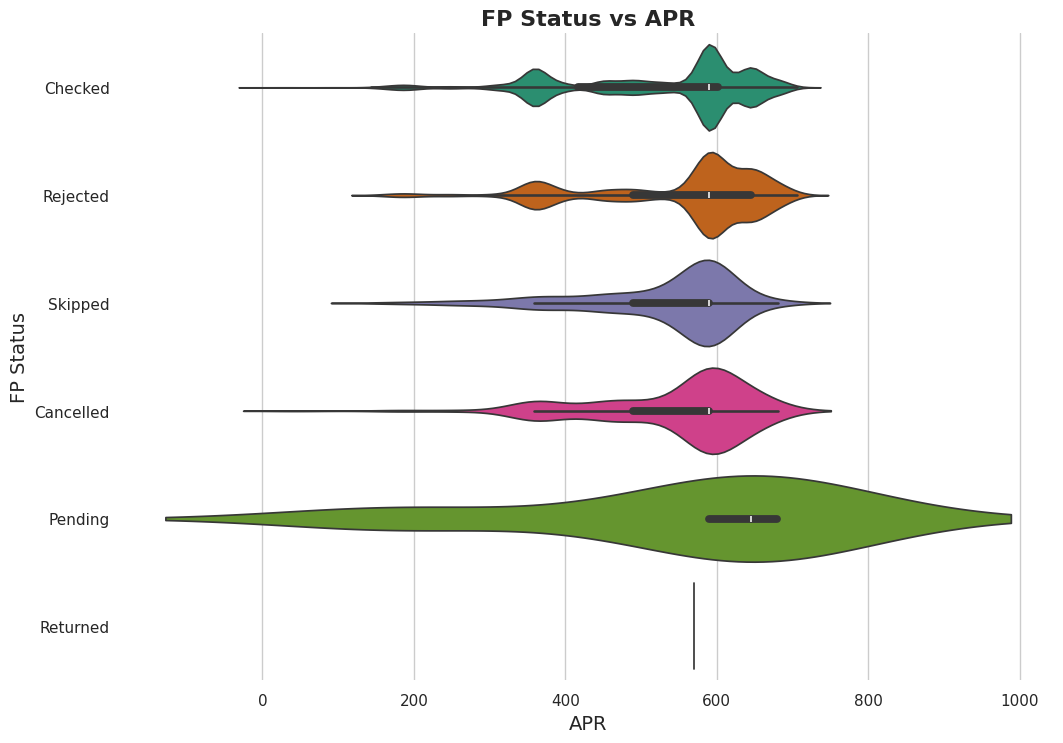

In [118]:
# @title fpStatus vs apr


sns.set_style("whitegrid")
sns.set_palette("Dark2")

figsize = (12, 1.2 * len(df['fpStatus'].unique()))


plt.figure(figsize=figsize)
sns.violinplot(data=df, x='apr', y='fpStatus', inner='box', scale='width', palette='Dark2')

plt.title('FP Status vs APR', fontsize=16, fontweight='bold')
plt.xlabel('APR', fontsize=14)
plt.ylabel('FP Status', fontsize=14)


sns.despine(top=True, right=True, bottom=True, left=True)

plt.show()


We can make several observations about the apr distribution across different fpStatus categories:

1. Checked: The distribution seems to be multimodal (having multiple peaks), suggesting there are several common apr values where loans that have been checked tend to concentrate.

2. Rejected: The apr values for rejected first payments are spread out but also show a multi-modal distribution. There could be common higher apr rates where rejections are more likely.

3. Skipped: The distribution is more compact, indicating less variation in apr among loans with skipped payments.

4. Cancelled: This category has a wide distribution, implying a diverse apr range, with a slight peak around the lower apr values.

5. Pending: The violin plot for pending status is quite flat and wide, suggesting that the apr values are uniformly distributed.

6. Returned: The shape is more concentrated around the median with less variability than in some other categories.

This visualization could help in the analysis of a loan fraud model by indicating how the apr correlates with the status of the first payment. For example, it might be found that higher apr rates are associated with a greater frequency of payment problems such as rejections and returns. This kind of insight would be valuable in predicting loan defaults or fraudulent activity.

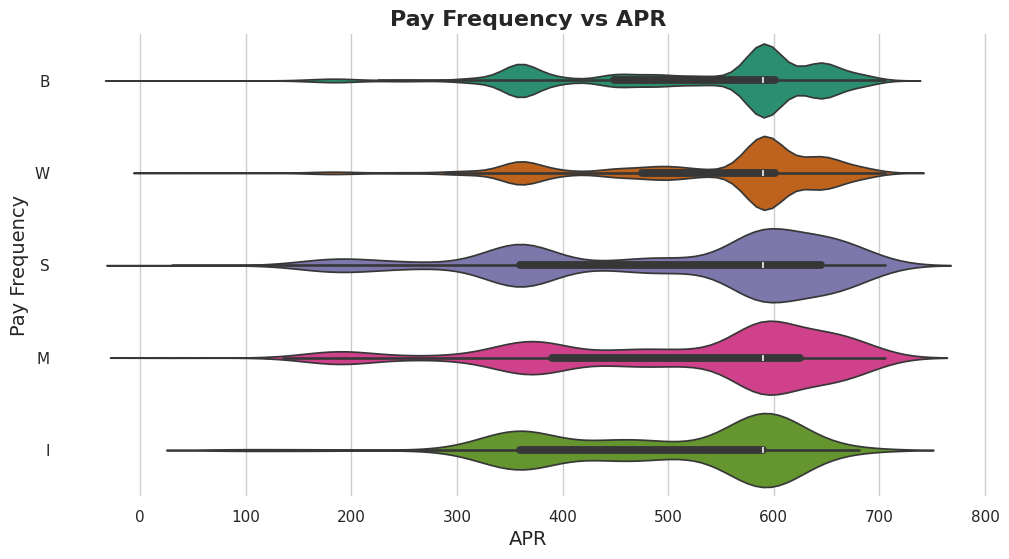

In [119]:
# @title payFrequency vs apr

sns.set_style("whitegrid")
sns.set_palette("Dark2")


figsize = (12, 1.2 * len(df['payFrequency'].unique()))


plt.figure(figsize=figsize)
sns.violinplot(data=df, x='apr', y='payFrequency', inner='box', scale='width', palette='Dark2')

plt.title('Pay Frequency vs APR', fontsize=16, fontweight='bold')
plt.xlabel('APR', fontsize=14)
plt.ylabel('Pay Frequency', fontsize=14)

sns.despine(top=True, right=True, bottom=True, left=True)

plt.show()



Bi-weekly (B): The distribution of APRs for bi-weekly payments shows a concentration around the median, indicating that most APR values are close to the median.

Weekly (W): This category has a broad distribution of APR values, suggesting more variability in the rates being offered to customers with weekly payments.

Semi-monthly (S): The distribution is relatively wide, implying a significant spread in the APR values for semi-monthly payments.

Monthly (M): The monthly payments show a concentration of APR values around the median, similar to bi-weekly payments but with a slightly broader distribution.

Irregular (I): Irregular payments show a broad and flat distribution, indicating a wide variety of APRs, potentially due to the non-standard nature of these payment terms.

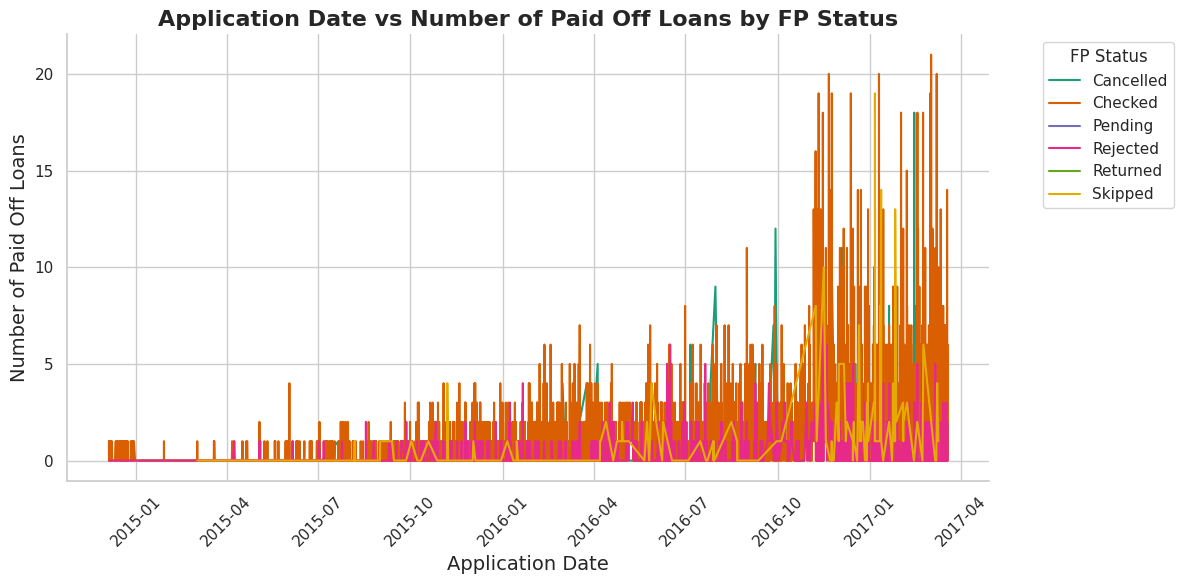

In [120]:
# @title applicationDate vs nPaidOff


sns.set_style("whitegrid")


def _plot_series(series, series_name, series_index=0, palette=None):
    if palette is None:
        palette = sns.color_palette('Dark2')
    xs = pd.to_datetime(series['applicationDate'])
    ys = series['nPaidOff']

    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])


fig, ax = plt.subplots(figsize=(12, 6))
df_sorted = df.sort_values('applicationDate', ascending=True)


palette = sns.color_palette('Dark2')
for i, (series_name, series) in enumerate(df_sorted.groupby('fpStatus')):
    _plot_series(series, series_name, i, palette=palette)


plt.title('Application Date vs Number of Paid Off Loans by FP Status', fontsize=16, fontweight='bold')
plt.xlabel('Application Date', fontsize=14)
plt.ylabel('Number of Paid Off Loans', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='FP Status', bbox_to_anchor=(1.05, 1), loc='upper left')

sns.despine()

plt.tight_layout()
plt.show()


1. By stacking the fpStatus categories over the applicationDate, we can observe how the distribution of first payment statuses changes over time. It may indicate trends such as an increase in certain payment statuses at specific times.

2. The height of each colored segment in the bars shows the count of loans with a particular nPaidOff value for each fpStatus category. If higher bars are visible, this indicates more clients with that particular number of paid-off loans for the specific first payment status.

3. If we see a lot of 'Checked' statuses with high nPaidOff values, it may suggest that clients who have paid off multiple loans in the past continue to perform well. On the other hand, a high number of 'Rejected' or 'Returned' statuses with high nPaidOff could indicate potential issues in the lending criteria or changes in the financial status of previously reliable borrowers.

4. There might be patterns indicating seasonality in loan applications and performance, such as an increase in 'Rejected' payments during specific months which could align with economic cycles or spending behavior (like holiday seasons).

5. The distribution of fpStatus over time can provide insights into the effectiveness of the underwriting process and whether certain periods have higher risk profiles than others.

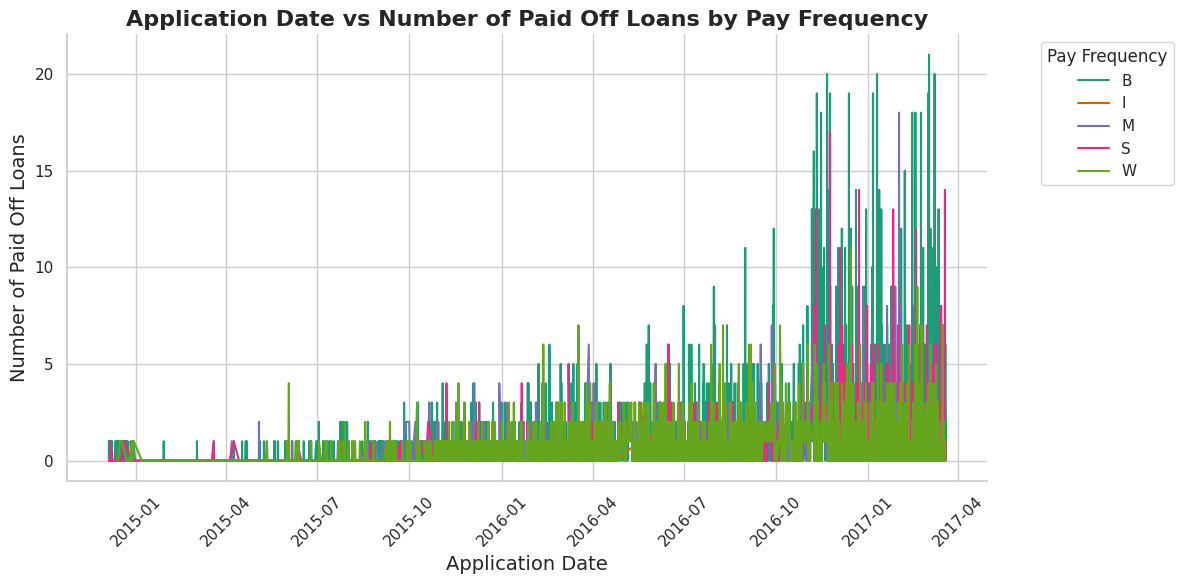

In [121]:
# @title applicationDate vs nPaidOff
sns.set_style("whitegrid")


def _plot_series(series, series_name, series_index=0, palette=None):
    if palette is None:
        palette = sns.color_palette('Dark2')
    xs = pd.to_datetime(series['applicationDate'])
    ys = series['nPaidOff']

    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])


fig, ax = plt.subplots(figsize=(12, 6))
df_sorted = df.sort_values('applicationDate', ascending=True)


palette = sns.color_palette('Dark2')
for i, (series_name, series) in enumerate(df_sorted.groupby('payFrequency')):
    _plot_series(series, series_name, i, palette=palette)


plt.title('Application Date vs Number of Paid Off Loans by Pay Frequency', fontsize=16, fontweight='bold')
plt.xlabel('Application Date', fontsize=14)
plt.ylabel('Number of Paid Off Loans', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Pay Frequency', bbox_to_anchor=(1.05, 1), loc='upper left')


sns.despine()

plt.tight_layout()
plt.show()


From this plot, you can infer several things:

1. How the number of paid-off loans has changed over the given period. For instance, you might observe seasonal trends or growth/shrinkage in the number of paid-off loans.

2. Which repayment frequencies are associated with higher numbers of paid-off loans. This could inform strategies to promote certain payment schedules.

3. This visualization could indirectly suggest which pay frequencies have better loan performance. For example, if a certain frequency consistently has more paid-off loans, it might be considered more reliable.

In terms of creating a loan fraud model:

1. Understanding the distribution of nPaidOff across different repayment frequencies might help in identifying patterns that are common among customers who do not default on their loans.

2. If certain frequencies show a propensity for customers to pay off their loans, it could be a signal of lower risk, which would be valuable information for the model.

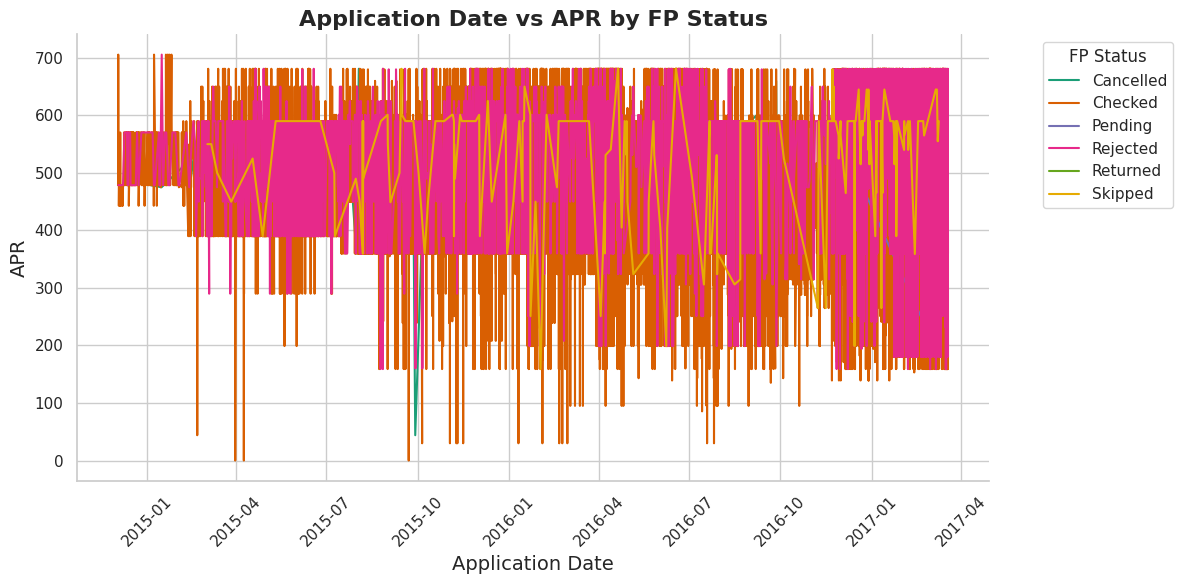

In [122]:
# @title applicationDate vs apr


sns.set_style("whitegrid")


def _plot_series(series, series_name, series_index=0, palette=None):
    if palette is None:
        palette = sns.color_palette('Dark2')
    xs = pd.to_datetime(series['applicationDate'])
    ys = series['apr']

    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])


fig, ax = plt.subplots(figsize=(12, 6))
df_sorted = df.sort_values('applicationDate', ascending=True)


palette = sns.color_palette('Dark2')
for i, (series_name, series) in enumerate(df_sorted.groupby('fpStatus')):
    _plot_series(series, series_name, i, palette=palette)


plt.title('Application Date vs APR by FP Status', fontsize=16, fontweight='bold')  # Adding a meaningful title
plt.xlabel('Application Date', fontsize=14)
plt.ylabel('APR', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='FP Status', bbox_to_anchor=(1.05, 1), loc='upper left')


sns.despine()


plt.tight_layout()


plt.show()


The APR (apr) varies over time, which is depicted by the vertical lines spanning from the bottom to the top of the plot. This variability could be due to changes in market interest rates, risk assessments, or lending policies.

Categorization: The different colors represent the different categories of the first payment status (fpStatus). The legend suggests that we have categories for payments that are checked, canceled, pending, rejected, returned, and skipped.

Density and Outliers: Where lines are dense and overlapping, it suggests many loans are concentrated around certain APR values for each fpStatus category during those times. Outliers, where lines extend to the top or bottom of the plot outside the denser areas, indicate less common APR values for loans in each status category.

Time Trends: By observing the concentration of lines vertically, one could infer periods of higher or lower APR values. If certain periods show denser clusters of higher APR values, it could indicate a shift in lending policy or external economic conditions affecting the rates offered.

Status Significance: If certain fpStatus categories like 'Rejected' or 'Pending' consistently appear at higher APR levels, it could suggest that higher rates are correlated with these statuses. For instance, higher APRs might be indicative of higher risk, leading to more rejections or pending statuses.

In the context of creating a loan fraud model:

The time trend of APR might inform the model that the economic or business factors affecting APRs change over time, which in turn might influence the likelihood of a loan being paid off or defaulting.
If certain fpStatus categories are correlated with higher or lower APRs, this might be a significant feature in predicting loan default risk.

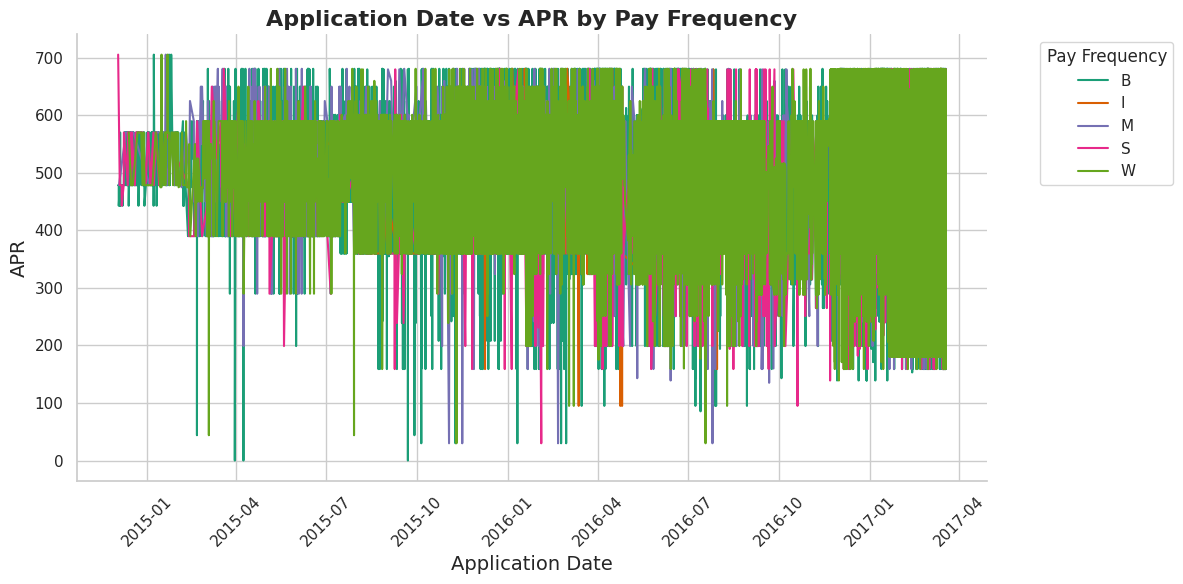

In [123]:
# @title applicationDate vs apr

sns.set_style("whitegrid")


def _plot_series(series, series_name, series_index=0, palette=None):
    if palette is None:
        palette = sns.color_palette('Dark2')

    xs = pd.to_datetime(series['applicationDate'])
    ys = series['apr']


    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])


fig, ax = plt.subplots(figsize=(12, 6))
df_sorted = df.sort_values('applicationDate', ascending=True)


palette = sns.color_palette('Dark2')
for i, (series_name, series) in enumerate(df_sorted.groupby('payFrequency')):
    _plot_series(series, series_name, i, palette=palette)


plt.title('Application Date vs APR by Pay Frequency', fontsize=16, fontweight='bold')
plt.xlabel('Application Date', fontsize=14)
plt.ylabel('APR', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Pay Frequency', bbox_to_anchor=(1.05, 1), loc='upper left')


sns.despine()


plt.tight_layout()


plt.show()




1. The plot displays the changes in APR over time for different payment frequencies. It allows us to observe trends, seasonality, or any anomalies in the APR rates across different times.

2. Each vertical line represents the range of APRs for loans initiated on a particular date, with the color coding corresponding to the payment frequency. The thickness of these lines at any given time point might suggest the volume of loans with that specific APR and payment frequency.

3. The vertical spread of the lines shows the variability in the APR for loans on different application dates. A longer line indicates a wider range of APRs offered on that date.

4. By comparing different colors, we can infer which payment frequency typically has higher or lower APRs, which could be critical for risk assessment and loan pricing.



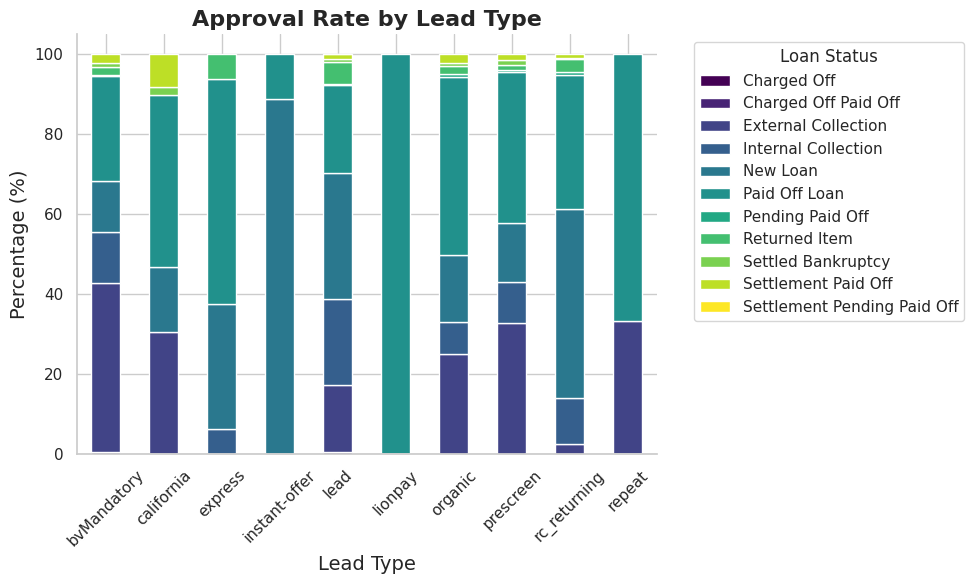

In [124]:
# @title Approval Rate by Lead Type
sns.set_style("whitegrid")


approval_rate_by_lead = df.groupby('leadType')['loanStatus'].value_counts(normalize=True).unstack() * 100  # Convert to percentage

fig, ax = plt.subplots(figsize=(10, 6))
approval_rate_by_lead.plot(kind='bar', stacked=True, ax=ax, colormap='viridis')

plt.title('Approval Rate by Lead Type', fontsize=16, fontweight='bold')
plt.xlabel('Lead Type', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Loan Status', bbox_to_anchor=(1.05, 1), loc='upper left')

sns.despine()

plt.tight_layout()

plt.show()


1. Certain lead types, like "prescreen" and "organic", have a higher proportion of "Paid Off Loan" status, suggesting that leads from these sources perform well in terms of repayments.

2. Other lead types, like "lionpay" and "repeat", have more diverse statuses with significant portions in "Pending Paid Off" and "New Loan" statuses.

3. The "bvMandatory" lead type has a notable proportion of "Charged Off" and "External Collection", which might suggest leads from this category carry higher risk.

In terms of creating a loan fraud model:

1. The proportions of loan statuses like "Charged Off" or "Collection" could help in assessing the risk associated with each lead type. Lead types with higher percentages of negative statuses could be flagged for more careful scrutiny.

2. The lead type could be used as a categorical feature in the model, as it seems to have a relationship with the likelihood of a loan being paid off or going into a negative status.

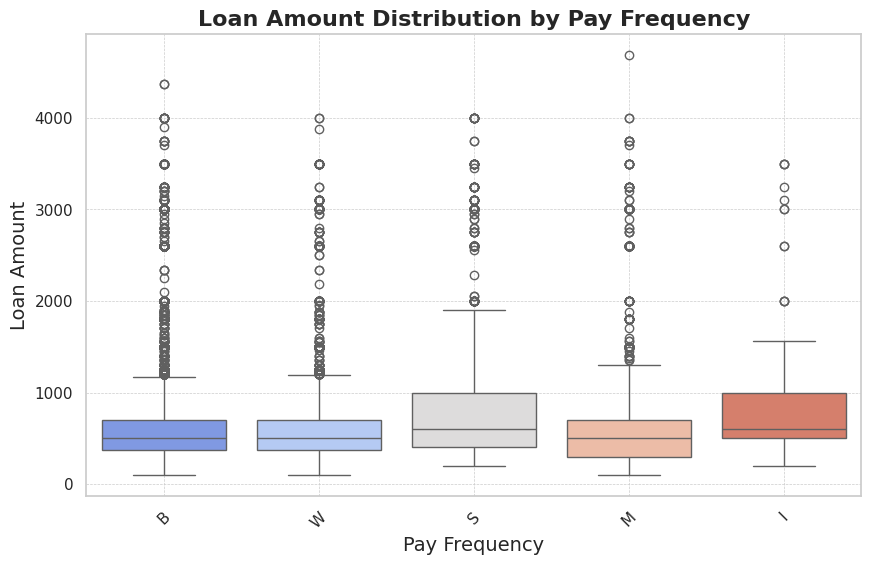

In [125]:
# @title Loan Amount Distribution by Pay Frequency
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of seaborn
sns.set_style("whitegrid")

# Create a boxplot
plt.figure(figsize=(10, 6))  # Set the figure size
sns.boxplot(x='payFrequency', y='loanAmount', data=df, palette="coolwarm")

# Customize the plot with titles, labels, and other aesthetics
plt.title('Loan Amount Distribution by Pay Frequency', fontsize=16, fontweight='bold')
plt.xlabel('Pay Frequency', fontsize=14)
plt.ylabel('Loan Amount', fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels to make them readable
plt.grid(True, which="both", ls="--", linewidth=0.5)  # Customize grid lines

# Show the plot
plt.show()



1. Bi-weekly (B) and weekly (W) payment frequencies have a larger number of outliers with higher loan amounts, which could indicate that these frequencies are chosen for both small and larger loans.

2. Monthly (M) payments show a fairly uniform distribution with fewer outliers, suggesting that the loan amounts for monthly payments are more consistent.

3. Semi-monthly (S) and irregular (I) payments also display outliers but to a lesser extent, which might indicate variability in loan amounts but less so than the bi-weekly and weekly categories.

4. The median loan amount is fairly consistent across different payment frequencies, although the median for weekly payments appears to be slightly lower.

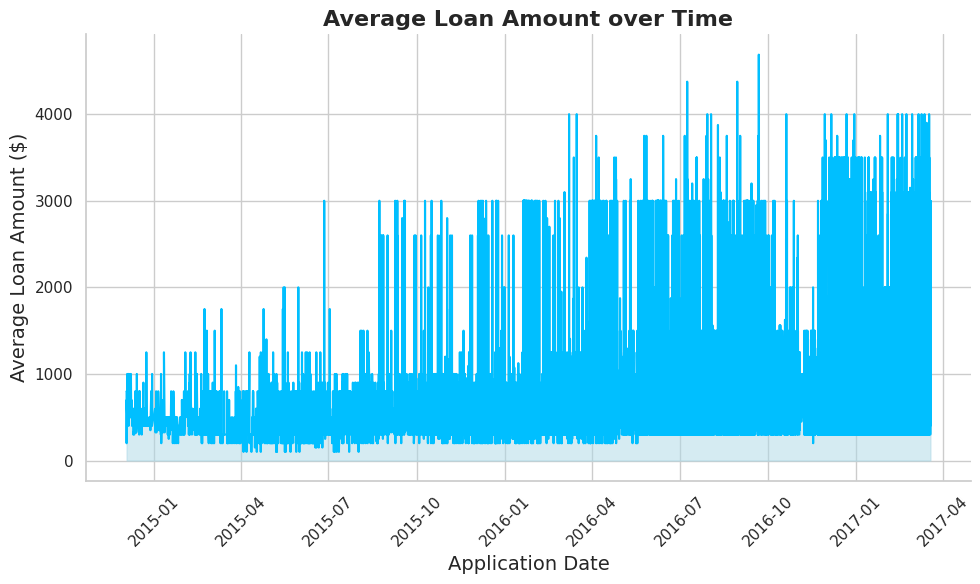

In [126]:
# @title Average Loan Amount over Time
sns.set_style("whitegrid")


df_grouped = df.groupby('applicationDate')['loanAmount'].mean()

plt.figure(figsize=(10, 6))
plt.plot(df_grouped.index, df_grouped.values, color='deepskyblue', label='Average Loan Amount')
plt.fill_between(df_grouped.index, df_grouped.values, color='lightblue', alpha=0.5)


plt.title('Average Loan Amount over Time', fontsize=16, fontweight='bold')
plt.xlabel('Application Date', fontsize=14)
plt.ylabel('Average Loan Amount ($)', fontsize=14)
plt.xticks(rotation=45)

sns.despine()

plt.tight_layout()

plt.show()


1. Each bar seems to correspond to a time interval (possibly a month) and shows the volume of loan applications for that period.

2. There is a noticeable trend in the data with periodic peaks, which could indicate seasonality in loan application volumes. The highest peaks might correspond to times of the year when more people apply for loans.

3. It's important to note when the peaks occur, as this might reveal important business insights—such as increased loan applications during holiday seasons or at the start of school terms.

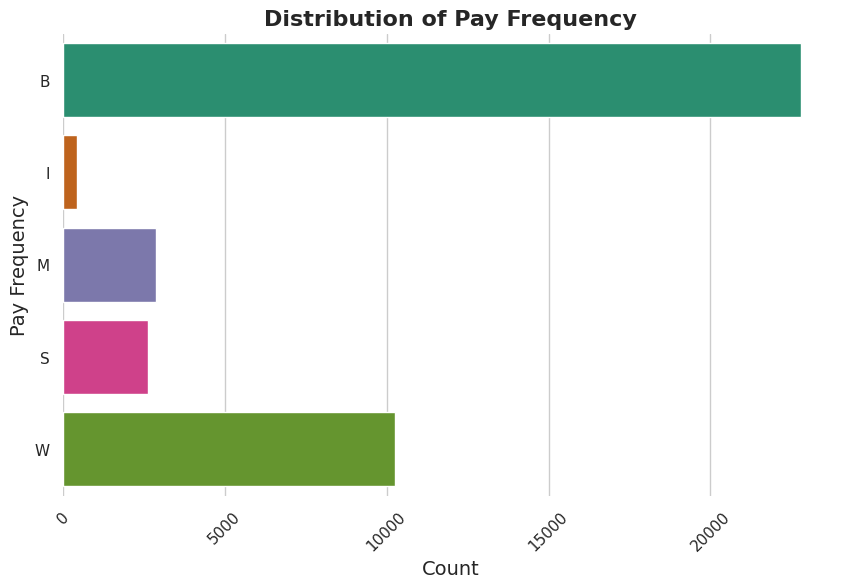

In [127]:
# @title payFrequency
sns.set_style("whitegrid")

# Plotting
plt.figure(figsize=(10, 6))
pay_frequency_counts = df.groupby('payFrequency').size()
sns.barplot(y=pay_frequency_counts.index, x=pay_frequency_counts.values, palette='Dark2', orient='h')

# Customize the plot
plt.title('Distribution of Pay Frequency', fontsize=16, fontweight='bold')
plt.xlabel('Count', fontsize=14)
plt.ylabel('Pay Frequency', fontsize=14)
plt.xticks(rotation=45)


sns.despine(left=True, bottom=True)


plt.show()


The category marked 'B' has the longest bar, suggesting that it has the highest count or total amount related to the loans among all the payment frequency categories.

'W' also has a long bar, indicating it's the second most frequent or largest by the total amount metric being measured.
'I' has the shortest bar, which suggests it has the lowest count or total amount.

'M' and 'S' have moderate-length bars, which indicates that they have more occurrences or a larger total amount than 'I' but less than 'B' and 'W'.

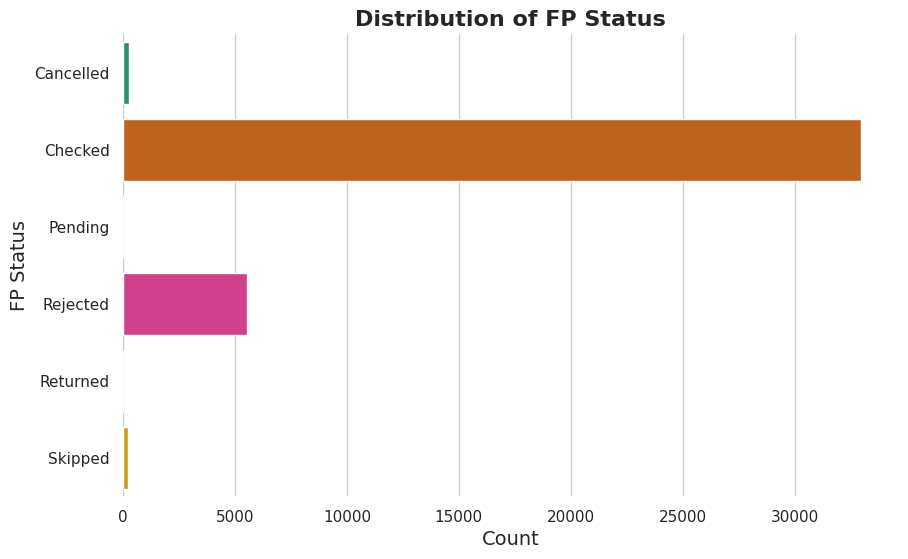

In [128]:
# @title fpStatus
sns.set_style("whitegrid")


fp_status_counts = df.groupby('fpStatus').size()


plt.figure(figsize=(10, 6))
sns.barplot(y=fp_status_counts.index, x=fp_status_counts.values, palette='Dark2', orient='h')


plt.title('Distribution of FP Status', fontsize=16, fontweight='bold')
plt.xlabel('Count', fontsize=14)
plt.ylabel('FP Status', fontsize=14)


sns.despine(left=True, bottom=True)


plt.show()


1. "Checked" Status: The longest bar indicates that the "Checked" status has the highest count among the categories. This likely means that most of the first payments have been successfully processed.

2. "Cancelled" and "Skipped" Statuses: These have the shortest bars, suggesting that there are relatively few instances where the first payment has been cancelled or skipped.

3. "Pending" and "Rejected" Statuses: These statuses have moderate counts, indicating a middle-ground frequency compared to the "Checked" and "Cancelled" statuses.

4. Variation in First Payment Status: There is a considerable variation in the frequency of different first payment outcomes, with "Checked" being the most common, which is a positive sign in terms of loan repayment.

For a loan fraud model:

1. A high number of "Checked" statuses could indicate a healthy loan portfolio with a good repayment start. However, a fraud model would need to verify these are genuine and not due to any manipulative practices.

2. High numbers of "Rejected" or "Cancelled" first payments could be flags for potential fraud or credit risk.

3. "Skipped" payments could be particularly suspicious and might trigger additional investigation in a fraud detection system.

4. The distribution of first payment statuses could be incorporated into risk models as predictors for future loan performance.

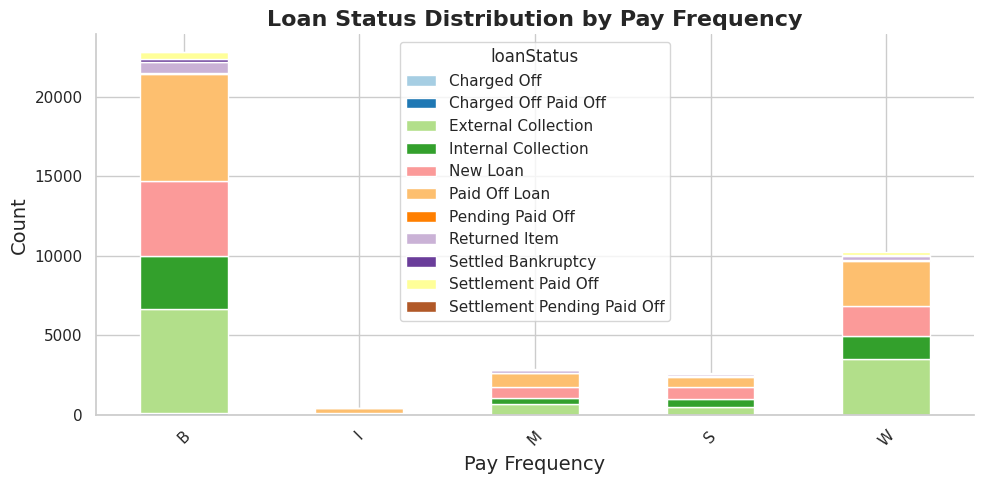

In [129]:
# @title Loan Status Distribution by Pay Frequency

sns.set_style("whitegrid")

loan_status_distribution = df.groupby(['payFrequency', 'loanStatus'])['loanId'].count().unstack()

fig, ax = plt.subplots(figsize=(10, 5))
loan_status_distribution.plot(kind='bar', stacked=True, colormap='Paired', ax=ax)

plt.title('Loan Status Distribution by Pay Frequency', fontsize=16, fontweight='bold')
plt.xlabel('Pay Frequency', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)

sns.despine()

plt.tight_layout()

plt.show()


Bi-weekly (B): This category has a high number of loans across various statuses, with a significant portion in "Paid Off Loan," which could suggest a higher completion rate for loans on this payment schedule.

Irregular (–): There's a low count of loans with irregular payment frequencies, indicating they are less common or perhaps more prone to issues given the presence of statuses like "Charged Off" and "External Collection."

Semi-monthly (Σ): This payment frequency shows a moderate number of loans and appears to have a high proportion of "Pending Paid Off" loans.

Weekly (W): Weekly payments have a tall bar primarily composed of "Paid Off Loan," suggesting a good track record of loan repayments on this schedule.

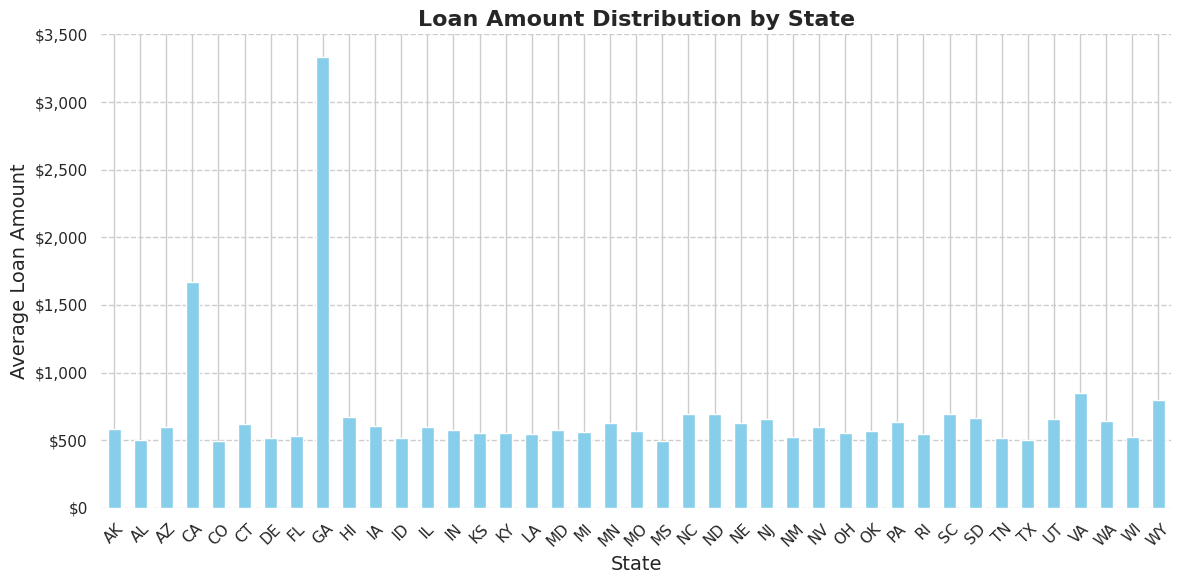

In [130]:
# @title Loan Amount Distribution by State
sns.set_style("whitegrid")

plt.figure(figsize=(12, 6))
df_state_avg = df.groupby('state')['loanAmount'].mean()
df_state_avg.plot(kind='bar', color='skyblue')


plt.title('Loan Amount Distribution by State', fontsize=16, fontweight='bold')
plt.xlabel('State', fontsize=14)
plt.ylabel('Average Loan Amount', fontsize=14)
plt.xticks(rotation=45)

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '${:,.0f}'.format(x)))


plt.grid(axis='y', linestyle='--')

sns.despine(left=True, bottom=True)

plt.tight_layout()


plt.show()


 1. The chart shows substantial variation in average loan amounts by state. This could be due to differences in economic conditions, lending regulations, or consumer behavior in different states.

2. Some states, like CA, show significantly higher average loan amounts than others. This might reflect the higher cost of living in these states or might indicate that the lending institution is more comfortable offering larger loans in these areas due to factors like average income or repayment history.

3. Model Training: When training a fraud detection model, it's important to account for such geographical variations. The model might learn that certain loan amounts are more typical in certain states and thus might not flag them as potential fraud in those regions, while the same amounts could be deemed suspicious in other states.


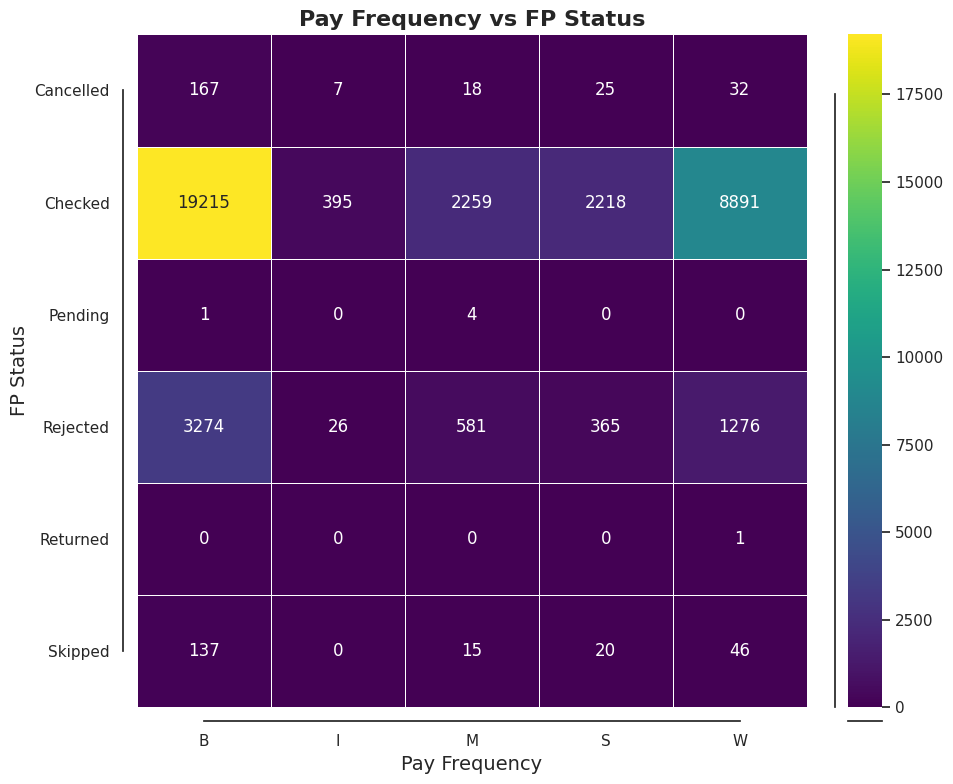

In [131]:
# @title payFrequency vs fpStatus
sns.set(style="white")

pivot_df = df.pivot_table(index='fpStatus', columns='payFrequency', aggfunc='size', fill_value=0)

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_df, cmap='viridis', annot=True, fmt="d", linewidths=.5)

plt.title('Pay Frequency vs FP Status', fontsize=16, fontweight='bold')
plt.xlabel('Pay Frequency', fontsize=14)
plt.ylabel('FP Status', fontsize=14)

sns.despine(offset=10, trim=True)

plt.tight_layout()

plt.show()


1. Bi-weekly (B) and weekly (W) payments seem to have a higher count of loans with a 'Checked' status, which may indicate that the first payments on these loans are often successful.

2. Monthly (M) payments show a significant number of loans with a 'Pending' status, suggesting many first payments are awaiting completion.

3. Irregular (I) and semi-monthly (S) payments have lower counts across all fpStatus categories, which might imply these are less common payment frequencies or have fewer issues with first payments.

In terms of loan fraud analysis:

1. Parts of the heatmap with darker colors (higher counts) can indicate common patterns or expected behaviors, which can be useful as benchmarks for detecting anomalies.

2. Lighter areas might be less common but could still be significant, especially if they represent potentially risky statuses like 'Rejected' or 'Cancelled'.

3. Consistent patterns across payment frequencies might reveal systematic issues or behaviors in loan payments that could be relevant for fraud detection.

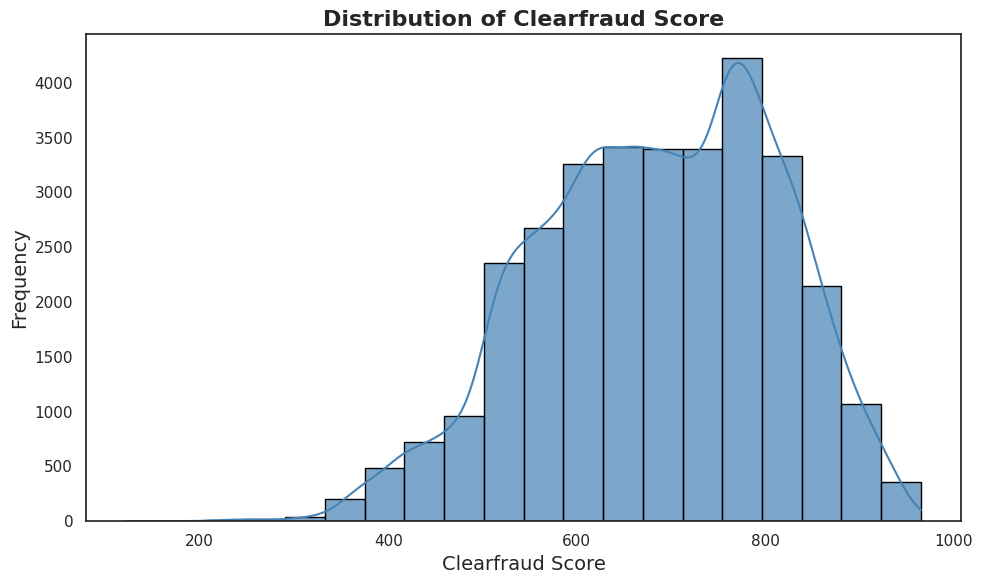

In [132]:
# @title Distribution of Clearfraud Score
sns.set_style("white")  # Provides a clean background


plt.figure(figsize=(10, 6))
sns.histplot(df['clearfraudscore'], bins=20, kde=True, color='steelblue', alpha=0.7, edgecolor='black')


plt.xlabel('Clearfraud Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)


plt.title('Distribution of Clearfraud Score', fontsize=16, fontweight='bold')


plt.grid(False)

plt.tight_layout()


plt.show()


1. The distribution looks roughly bell-shaped, indicating a normal distribution of Clearfraud scores. This suggests most scores are around the center of the range, with fewer scores at the extreme low and high ends.

2. The Clearfraud scores appear to range from below 200 to 1000, with the majority of scores concentrated in the middle of the range.

3. The tallest bars are around the 500 to 700 score range, which could be the average risk score for this set of loans or applicants.

3. If a higher Clearfraud score indicates a higher risk of fraud, then this histogram shows that most applicants or transactions are assessed to be of moderate risk.

4. There are fewer applicants or loans with very high or very low Clearfraud scores. If a low score indicates a lower risk, it suggests there are few 'very safe' loans, and similarly, few 'very high risk' loans.

## Imputing Missing Values

We proceed accordingly by checking whether there are any missing values present in our data.

In [133]:
# @title check_nan()

def check_nan(df):
    """
    This enhanced function calculates the percentage of missing values in each column of a pandas dataframe
    and returns a styled DataFrame with these percentages for columns with missing values only. Columns are color-coded
    to highlight the severity of missing data.

    Args:
        df: A pandas DataFrame.

    Returns:
        A styled pandas DataFrame object that color-codes the missing percentages to make high missing values stand out.
    """

    # Calculate percentage of missing values
    missing_values_percentage = df.isnull().mean() * 100

    # Filter to include only columns with missing values and sort them by descending order of missing percentage
    missing_values_filtered = missing_values_percentage[missing_values_percentage > 0].sort_values(ascending=False)

    # Format as percentages with 2 decimals and convert to DataFrame
    missing_values_df = pd.DataFrame(missing_values_filtered.round(2), columns=['Missing Percentage'])

    # Define a styling function to color-code the missing percentages
    def color_missing_values(val):
        """
        Colors values based on their magnitude to highlight high percentages of missing values.
        """
        color = 'red' if val > 50 else 'orange' if val > 20 else 'green'
        return f'color: {color}'

    # Apply the styling function to the DataFrame
    styled_df = missing_values_df.style.applymap(color_missing_values, subset=['Missing Percentage'])\
                                        .format({'Missing Percentage': '{}%'})

    return styled_df

#


In [134]:
# Compute % of missing values in each column
check_nan(df)

Notice that `clearfraudscore` and `nPaidOff` both have `NaN` values that we must handle (we'll most likely end up dropping `fpStatus` so we'll deal with that column later). Beginning with the former, let's first observe how the data are distributed.

In [135]:
# Fill missing values
df.loc[df['clearfraudscore'].isna(), 'clearfraudscore'] = df['clearfraudscore'].median()
df.loc[df['nPaidOff'].isna(), 'nPaidOff'] = df['nPaidOff'].mode()[0]


## Impute Categorical Variables

Next, we'll look over the dtype of each column, keeping an eye out for any categorical variables

In [136]:
# Print concise summary of df
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38982 entries, 1 to 577662
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   loanId                            38982 non-null  object        
 1   anon_ssn                          38982 non-null  object        
 2   payFrequency                      38982 non-null  object        
 3   apr                               38982 non-null  float64       
 4   applicationDate                   38982 non-null  datetime64[ns]
 5   originatedDate                    38982 non-null  datetime64[ns]
 6   nPaidOff                          38982 non-null  float64       
 7   loanStatus                        38982 non-null  object        
 8   loanAmount                        38982 non-null  float64       
 9   originallyScheduledPaymentAmount  38982 non-null  float64       
 10  state                             38982 non-n

We notice several columns with `dtype == 'object'`, which we'll address in order:

- `loanId` & `anon_ssn` are unique identifiers -> no further action required
- `payFrequency` may be of use to us -> **further action required**
- `loanStatus` will be addressed during feature engineering -> skip for now
- `state` contains demographic data, which we'll refrain from using due to the potential for bias/discrimination (see "Further Work" section) -> drop column
- `leadType` may be of use to us -> **further action required**
- `fpStatus` contains data that won't be available during model prediction (i.e. target leakage) -> drop column

It follows, since `payFrequency` is an ordinal variable, whereas `leadType` is a nominal variable, we'll apply ordinal & one-hot encoding, respectively.

In [137]:
# Drop irrelevant columns
df = df.drop(columns=['state', 'fpStatus'])
# Ordinal encoding
df['payFrequency'] = df['payFrequency'].map({'W': 0,
                                             'B': 1,
                                             'S': 2,
                                             'M': 3,
                                             'I': 4})
# One-hot encoding
df = pd.get_dummies(df, columns=['leadType'])
# Display results
df

loanId                          anon_ssn  payFrequency    apr  \
1       LL-I-06644937  464f5d9ae4fa09ece4048d949191865c             1  199.0   
15      LL-I-12263369  accf40708233e8b7d05fcb89d5a9c081             1  475.0   
33      LL-I-17826953  7529d29c9d943cc55bc71a85d9c6b7a3             0  645.0   
47      LL-I-16519347  bc9fa73468acf18cb968a3a6a3c4697c             2  490.0   
54      LL-I-11506719  10cefd11d41612b032fd9cd2debe32dc             1  590.0   
...               ...                               ...           ...    ...   
577564  LL-I-12367915  55392b05f72f8c3e32e5157612406ba8             1  565.0   
577590  LL-I-15280684  73690518af906288434b2a0cfd972fe0             3  645.0   
577617  LL-I-09897110  0538f828b4a0b44502ead5a8033ee779             1  449.0   
577653  LL-I-14178923  d9a63e9e15b862fcaaf3653c52e1f16c             1  625.0   
577662  LL-I-13311312  043dd86c24c63c8968082fa3ad7a8911             0  645.0   

               applicationDate          originatedDate  nPaidOff  \
1      2016-01-19 22:07:36.778 2016-01-20 15:49:18.846       0.0   
15     2016-11-28 19:54:22.982 2016-11-29 20:30:40.640       2.0   
33     2017-03-01 15:55:41.823 2017-03-01 16:15:13.016       0.0   
47     2017-01-31 17:48:17.381 2017-01-31 18:00:14.520       2.0   
54     2016-08-27 09:08:05.442 2016-08-29 15:05:04.014       0.0   
...                        ...                     ...       ...   
577564 2016-12-01 16:57:49.231 2016-12-01 17:28:21.872       3.0   
577590 2017-01-14 19:43:08.685 2017-01-14 20:00:10.426       0.0   
577617 2016-06-22 01:10:50.110 2016-06-22 21:46:54.359       0.0   
577653 2016-12-30 15:49:39.785 2016-12-30 16:00:12.500       0.0   
577662 2016-12-16 20:20:30.157 2016-12-16 23:15:06.874       0.0   

           loanStatus  loanAmount  originallyScheduledPaymentAmount  leadCost  \
1       Paid Off Loan      3000.0                           6395.19         0   
15           New Loan       350.0                            893.88         0   
33           New Loan       400.0                           1364.87        40   
47      Paid Off Loan      1250.0                           3313.78         0   
54      Paid Off Loan       800.0                           2432.08        10   
...               ...         ...                               ...       ...   
577564  Paid Off Loan       600.0                           1670.18         0   
577590  Paid Off Loan       375.0                           1042.40        25   
577617  Paid Off Loan       400.0                            664.12        40   
577653       New Loan       600.0                           1868.88        25   
577662  Paid Off Loan       300.0                           1034.38         6   

        hasCF  clearfraudscore  leadType_bvMandatory  leadType_california  \
1           1            879.0                     0                    0   
15          0            693.0                     0                    0   
33          1            658.0                     0                    0   
47          1            835.0                     0                    0   
54          1            624.0                     1                    0   
...       ...              ...                   ...                  ...   
577564      0            693.0                     0                    0   
577590      1            700.0                     0                    0   
577617      1            806.0                     0                    0   
577653      1            769.0                     0                    0   
577662      1            827.0                     0                    0   

        leadType_express  leadType_instant-offer  leadType_lead  \
1                      0                       0              0   
15                     0                       0              0   
33                     0                       0              1   
47                     0                       0              0   
54  


## Feature Engineering

Moving on, we'd now like to create a target variable to represent whether a given loan application has defaulted or not. For this, we turn to the `loanStatus` column, which gives us a high-level overview of the outcomes of each application.

In [138]:
# Perform a normalized count of unique values in loanStatus
df['loanStatus'].value_counts(normalize=True).apply(lambda x: f'{x * 100:.2f}%')

Paid Off Loan                  29.31%
External Collection            29.07%
New Loan                       20.81%
Internal Collection            14.27%
Returned Item                   3.03%
Settlement Paid Off             1.82%
Settled Bankruptcy              0.83%
Pending Paid Off                0.43%
Charged Off Paid Off            0.41%
Charged Off                     0.00%
Settlement Pending Paid Off     0.00%
Name: loanStatus, dtype: object

We gather the following information:
1. `Paid Off Loan` and `Settlement Paid Off` seem to indicate the loan was paid/settled in full, which are favorable outcomes from the perspective of the lender (MoneyLion).
2. `Settled Bankruptcy` and `Charged Off` indicates the client failed to fulfill their financial obligations, necessitating 3rd-party intervention & a loss on MoneyLion's end. These outcomes are what we're trying to avoid.
3. All other values indicate that the status of the loan is still ongoing, and are thus irrelevant to our analyses.

With that, we can create a new `target` column with a binary value indicating whether `loanStatus` is favorable (`target == 1`) or not (`target == 0`); we'll drop all other entries.

In [139]:
# Map loan status to target (0: loan default, 1: loan didn't default)
def target_encoding(x):
    labels = {0: ['Settled Bankruptcy', 'Charged Off'],
              1: ['Paid Off Loan', 'Settlement Paid Off']}
    for label, status in labels.items():
        if x in status:
            return label
df['target'] = df['loanStatus'].map(target_encoding)
# Drop rows with no target label (implying their status is ongoing)
df = df[df['target'].notna()].reset_index(drop=True)
# Display results
df['target'].value_counts(normalize=True).apply(lambda x: f'{x * 100:.2f}%')

1.0    97.38%
0.0     2.62%
Name: target, dtype: object

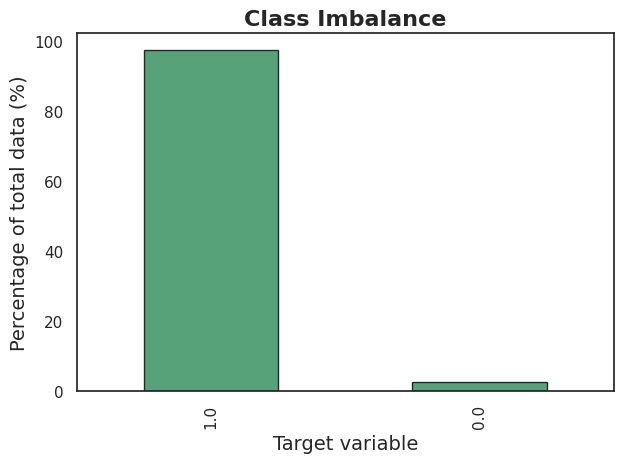

<Figure size 640x480 with 0 Axes>

In [140]:
# @title Class Imbalance Count plot

# Create a bar chart with customized styling
df['target'].value_counts(normalize=True).apply(lambda x: round(x * 100, 2)).plot(kind='bar', color='seagreen', alpha=0.8, edgecolor='black')

# Format the x and y axis labels
plt.xlabel('Target variable', fontsize=14)
plt.ylabel('Percentage of total data (%)', fontsize=14)

# Customize the title
plt.title('Class Imbalance', fontsize=16, fontweight='bold')

# Remove the grid lines
plt.grid(False)

# Adjust the layout
plt.tight_layout()

# Display the plot
plt.show()

# Save the plot to a file
plt.savefig('./class_imbalance.png', format='png')

Expectedly, we have a significant class imbalance against defaulted loans, which we'll need to address during preprocessing.

Notice, we can now drop the `loanStatus` column, as we've extracted & summarized all the necessary information into `target`.

We'll also choose to drop `hasCF`, since (1) we have no information on what this column represents according to the attached instructions, and (2) assuming "CF" stands for "clear fraud", one can further assume that `clearfraudscore` already holds most of the intrinsic information in `hasCF`, allowing us to safely drop it from consideration (also recall our initial assumption that the underwriting team will have rejected the majority of fraudulent applications). Though, in a real-world scenario, it'd be best to ask for clarification before doing so.

In [141]:
# Drop irrelevant columns
df.drop(columns=['loanStatus', 'hasCF'], inplace=True)

It remains to engineer additional features out of the available data. Note the utility of taking an inventory of our current features, as to better inform the feature engineering process:

- `loan_id` & `anon_ssn` can be used to identify and track the client.
- `applicationDate` & `originatedDate` provide information on the timing of the loan.
- `loanAmount` & `apr` provide information on the cost of borrowing, which can be used to assess the affordability of the loan.
- `payFrequency` & `originallyScheduledPaymentAmount` provide information on the terms of the loan, which can be used to assess the client's ability to make regular payments.
- `nPaidOff` provides information on the client's loan repayment history, which is relevant to determining the client's trustworthiness.
- `leadType` & `leadCost` can provide information on the source & cost of obtaining the loan, which may be relevant to assessing the quality of the loan.
- `clearfraudscore` can be used to identify and flag any potential fraud.

Based on this, a potential feature could be `time_to_originate`, calculated from the difference between `application_date` & `originated_date`, in hours. This can provide information on the time it took for the loan to be originated, which may be relevant to assessing the quality of the application.

In [142]:
# Calculate hours between applicationDate & originatedDate
df['time_to_originate'] = (df['originatedDate'] - df['applicationDate']).dt.seconds / 3600
# Display results
df.head()

loanId                          anon_ssn  payFrequency    apr  \
0  LL-I-06644937  464f5d9ae4fa09ece4048d949191865c             1  199.0   
1  LL-I-16519347  bc9fa73468acf18cb968a3a6a3c4697c             2  490.0   
2  LL-I-11506719  10cefd11d41612b032fd9cd2debe32dc             1  590.0   
3  LL-I-09279047  1d249e27292d25e4d3b4bc142a2a4aea             0  404.1   
4  LL-I-01316580  2a10b2e04c5eec9a47a8cf5b9b81a2b8             0  590.0   

          applicationDate          originatedDate  nPaidOff  loanAmount  \
0 2016-01-19 22:07:36.778 2016-01-20 15:49:18.846       0.0      3000.0   
1 2017-01-31 17:48:17.381 2017-01-31 18:00:14.520       2.0      1250.0   
2 2016-08-27 09:08:05.442 2016-08-29 15:05:04.014       0.0       800.0   
3 2016-05-25 03:05:18.849 2016-05-25 15:11:36.260       3.0       300.0   
4 2015-05-26 17:02:27.312 2015-05-26 18:45:48.024       0.0       300.0   

   originallyScheduledPaymentAmount  leadCost  clearfraudscore  \
0                           6395.19         0            879.0   
1                           3313.78         0            835.0   
2                           2432.08        10            624.0   
3                            422.64         0            770.0   
4                            896.87         6            693.0   

   leadType_bvMandatory  leadType_california  leadType_express  \
0                     0                    0                 0   
1                     0                    0                 0   
2                     1                    0                 0   
3                     0                    0                 0   
4                     1                    0                 0   

   leadType_instant-offer  leadType_lead  leadType_lionpay  leadType_organic  \
0                       0              0                 0                 0   
1                       0              0                 0                 1   
2                       0              0                 0                 0   
3                       0              0                 0                 1   
4                       0              0                 0                 0   

   leadType_prescreen  leadType_rc_returning  leadType_repeat  target  \
0                   1                      0                0     1.0   
1                   0                      0                0     1.0   
2                   0                      0                0     1.0   
3                   0                      0                0     1.0   
4                   0                      0                0     1.0   

   time_to_originate  
0          17.695000  
1           0.199167  
2           5.949444  
3          12.104722  
4           1.722222

Another useful feature is `time_since_last`, which represents the time between consecutive loan applications by a given person, in days. For non-returning clients, this value will be -1.

In [143]:
# Create a copy of df and sort the values by ssn & applicationDate
tmp = df.sort_values(by=['anon_ssn', 'applicationDate']).copy()
# Compute the days between consecutive applications
df['time_since_last'] = tmp.groupby('anon_ssn')['applicationDate'].diff().dt.total_seconds() / (24 * 60 * 60)
# Fill NaN values
df['time_since_last'] = df['time_since_last'].fillna(-1)
# Display results
df.head()

loanId                          anon_ssn  payFrequency    apr  \
0  LL-I-06644937  464f5d9ae4fa09ece4048d949191865c             1  199.0   
1  LL-I-16519347  bc9fa73468acf18cb968a3a6a3c4697c             2  490.0   
2  LL-I-11506719  10cefd11d41612b032fd9cd2debe32dc             1  590.0   
3  LL-I-09279047  1d249e27292d25e4d3b4bc142a2a4aea             0  404.1   
4  LL-I-01316580  2a10b2e04c5eec9a47a8cf5b9b81a2b8             0  590.0   

          applicationDate          originatedDate  nPaidOff  loanAmount  \
0 2016-01-19 22:07:36.778 2016-01-20 15:49:18.846       0.0      3000.0   
1 2017-01-31 17:48:17.381 2017-01-31 18:00:14.520       2.0      1250.0   
2 2016-08-27 09:08:05.442 2016-08-29 15:05:04.014       0.0       800.0   
3 2016-05-25 03:05:18.849 2016-05-25 15:11:36.260       3.0       300.0   
4 2015-05-26 17:02:27.312 2015-05-26 18:45:48.024       0.0       300.0   

   originallyScheduledPaymentAmount  leadCost  clearfraudscore  \
0                           6395.19         0            879.0   
1                           3313.78         0            835.0   
2                           2432.08        10            624.0   
3                            422.64         0            770.0   
4                            896.87         6            693.0   

   leadType_bvMandatory  leadType_california  leadType_express  \
0                     0                    0                 0   
1                     0                    0                 0   
2                     1                    0                 0   
3                     0                    0                 0   
4                     1                    0                 0   

   leadType_instant-offer  leadType_lead  leadType_lionpay  leadType_organic  \
0                       0              0                 0                 0   
1                       0              0                 0                 1   
2                       0              0                 0                 0   
3                       0              0                 0                 1   
4                       0              0                 0                 0   

   leadType_prescreen  leadType_rc_returning  leadType_repeat  target  \
0                   1                      0                0     1.0   
1                   0                      0                0     1.0   
2                   0                      0                0     1.0   
3                   0                      0                0     1.0   
4                   0                      0                0     1.0   

   time_to_originate  time_since_last  
0          17.695000        -1.000000  
1           0.199167        13.688801  
2           5.949444        -1.000000  
3          12.104722        98.405253  
4           1.722222        -1.000000

One could also choose a feature like `num_previous_funded_loans`, indicating how many previously funded loans a client has had with MoneyLion in the past, at the time of the application. Though, upon closer inspection, we notice there are some missing entries.

For example, the following client is missing loans #0, #6, #10, and #14.

In [144]:
# Note: this ssn has the most entries on-file
df[df['anon_ssn'] == '228060b9cc8af6a937d0321122d459f3'].sort_values(by=['applicationDate'])

loanId                          anon_ssn  payFrequency     apr  \
11296  LL-I-04012560  228060b9cc8af6a937d0321122d459f3             1  449.99   
3067   LL-I-04358754  228060b9cc8af6a937d0321122d459f3             1  449.99   
4506   LL-I-05205561  228060b9cc8af6a937d0321122d459f3             1  449.99   
3101   LL-I-06837849  228060b9cc8af6a937d0321122d459f3             1  449.99   
1012   LL-I-08384112  228060b9cc8af6a937d0321122d459f3             1  449.99   
10786  LL-I-09327212  228060b9cc8af6a937d0321122d459f3             1  404.10   
9159   LL-I-10053275  228060b9cc8af6a937d0321122d459f3             1  404.10   
4292   LL-I-10680938  228060b9cc8af6a937d0321122d459f3             1  449.99   
5282   LL-I-11629173  228060b9cc8af6a937d0321122d459f3             1  449.99   
7016   LL-I-12081344  228060b9cc8af6a937d0321122d459f3             1  449.99   
3594   LL-I-12120038  228060b9cc8af6a937d0321122d459f3             1  449.99   
1722   LL-I-16760104  228060b9cc8af6a937d0321122d459f3             1  449.99   

              applicationDate          originatedDate  nPaidOff  loanAmount  \
11296 2015-10-23 14:56:26.973 2015-10-23 15:41:41.837       1.0       800.0   
3067  2015-11-05 19:28:54.692 2015-11-05 19:47:35.596       2.0       800.0   
4506  2015-12-01 21:44:50.958 2015-12-02 15:22:55.320       3.0       800.0   
3101  2016-01-27 16:52:33.451 2016-01-27 18:07:50.283       4.0       800.0   
1012  2016-04-04 14:07:52.556 2016-04-05 18:18:39.840       5.0       800.0   
10786 2016-05-26 19:57:32.706 2016-05-26 21:23:45.516       7.0       600.0   
9159  2016-06-30 15:14:52.727 2016-06-30 19:08:44.701       8.0       400.0   
4292  2016-07-30 20:19:50.936 2016-07-31 16:11:46.279       9.0      1000.0   
5282  2016-08-31 02:54:39.904 2016-08-31 15:02:27.824      11.0      1000.0   
7016  2016-09-28 15:53:32.914 2016-09-28 20:07:49.891      12.0      1000.0   
3594  2016-11-05 16:24:17.676 2016-11-07 23:06:08.769      13.0      1000.0   
1722  2017-02-06 10:12:49.225 2017-02-06 10:30:14.234      15.0       400.0   

       originallyScheduledPaymentAmount  leadCost  clearfraudscore  \
11296                           1722.75         0            614.0   
3067                            1318.06         0            614.0   
4506                            1389.67         0            693.0   
3101                            1359.82         0            614.0   
1012                            1449.38         0            614.0   
10786                            957.95         0            614.0   
9159                             692.24         0            614.0   
4292                            1811.70         0            752.0   
5282                            2051.77         0            752.0   
7016                            1664.27         0            752.0   
3594                            2640.41         0            752.0   
1722                            1048.73         0            693.0   

       leadType_bvMandatory  leadType_california  leadType_express  \
11296                     0                    0                 0   
3067                      0                    0                 0   
4506                      0                    0                 0   
3101                      0                    0                 0   
1012                      0                    0                 0   
10786                     0                    0                 0   
9159                      0                    0                 0   
4292                      0                    0                 0   
5282                      0                    0                 0   
7016                      0                    0                 0   
3594                      0                    0                 0   
1722                      0                    0                 0   

       leadType_instant-offer  leadType_lead  leadType_lionpay  \
11296                       0              0             

More explicitly, create a temporary column `loan_count` with the values one would expect without prior knowledge about the missing entries, and juxtapose it with `nPaidOff`.

In [145]:
# Count the number of distinct loan IDs up to (& excluding) the current application date
tmp = df.copy()
tmp = tmp.sort_values(by=['anon_ssn', 'applicationDate'])
tmp['loan_count'] = tmp.groupby(['anon_ssn'])['loanId'].cumcount()
tmp[tmp['anon_ssn'] == '228060b9cc8af6a937d0321122d459f3'][['anon_ssn', 'loanId','nPaidOff', 'loan_count']]

anon_ssn         loanId  nPaidOff  loan_count
11296  228060b9cc8af6a937d0321122d459f3  LL-I-04012560       1.0           0
3067   228060b9cc8af6a937d0321122d459f3  LL-I-04358754       2.0           1
4506   228060b9cc8af6a937d0321122d459f3  LL-I-05205561       3.0           2
3101   228060b9cc8af6a937d0321122d459f3  LL-I-06837849       4.0           3
1012   228060b9cc8af6a937d0321122d459f3  LL-I-08384112       5.0           4
10786  228060b9cc8af6a937d0321122d459f3  LL-I-09327212       7.0           5
9159   228060b9cc8af6a937d0321122d459f3  LL-I-10053275       8.0           6
4292   228060b9cc8af6a937d0321122d459f3  LL-I-10680938       9.0           7
5282   228060b9cc8af6a937d0321122d459f3  LL-I-11629173      11.0           8
7016   228060b9cc8af6a937d0321122d459f3  LL-I-12081344      12.0           9
3594   228060b9cc8af6a937d0321122d459f3  LL-I-12120038      13.0          10
1722   228060b9cc8af6a937d0321122d459f3  LL-I-16760104      15.0          11

Thus, due to the discrepancy, we'll refrain from using `num_previous_funded_loans` as a feature.

In fact, in the interest of time, we'll assume our currently implemented features will suffice. For further discussion regarding potential new data/features, see the "Further Work" section.

In [146]:
# Make a copy for exploratory analysis/visualization
data = df.copy()
# Print descriptive stats for numeric columns
data[['apr', 'nPaidOff', 'loanAmount', 'originallyScheduledPaymentAmount', 'leadCost', 'clearfraudscore', 'time_to_originate', 'time_since_last']].describe()

apr      nPaidOff    loanAmount  \
count  12461.000000  12461.000000  12461.000000   
mean     508.946662      0.590081    629.297007   
std      117.319897      1.389716    451.761168   
min        0.000000      0.000000    100.000000   
25%      390.000000      0.000000    350.000000   
50%      565.000000      0.000000    500.000000   
75%      590.000000      1.000000    700.000000   
max      705.590000     21.000000   4687.000000   

       originallyScheduledPaymentAmount      leadCost  clearfraudscore  \
count                      12461.000000  12461.000000     12461.000000   
mean                        1661.688210     12.109863       709.577482   
std                         1202.830803     24.749500       115.983220   
min                          188.410000      0.000000       177.000000   
25%                          950.230000      0.000000       655.000000   
50%                         1303.620000      3.000000       693.000000   
75%                         1943.700000     10.000000       794.000000   
max                        12550.080000    200.000000       961.000000   

       time_to_originate  time_since_last  
count       12461.000000     12461.000000  
mean            7.040876        26.693385  
std             7.638825        72.233430  
min             0.000000        -1.000000  
25%             0.715000        -1.000000  
50%             3.221111        -1.000000  
75%            13.698611        -1.000000  
max            23.998333       608.884541

Already, we see that the average funded loan at MoneyLion is for $629.30 in principal, at an APR of 5.089% (assuming the data are expressed in basis points), with an expected payment amount of $1661.69. Additionally, the average funded loan application takes 7.04 days to originate, and receives a clear fraud score of 709.58 from the underwriting team.

However, without prior knowledge of how these data are distributed, it's difficult to tell how useful these statistics truly are.

Subsequently, we move on to the features concerning the terms of the loans.

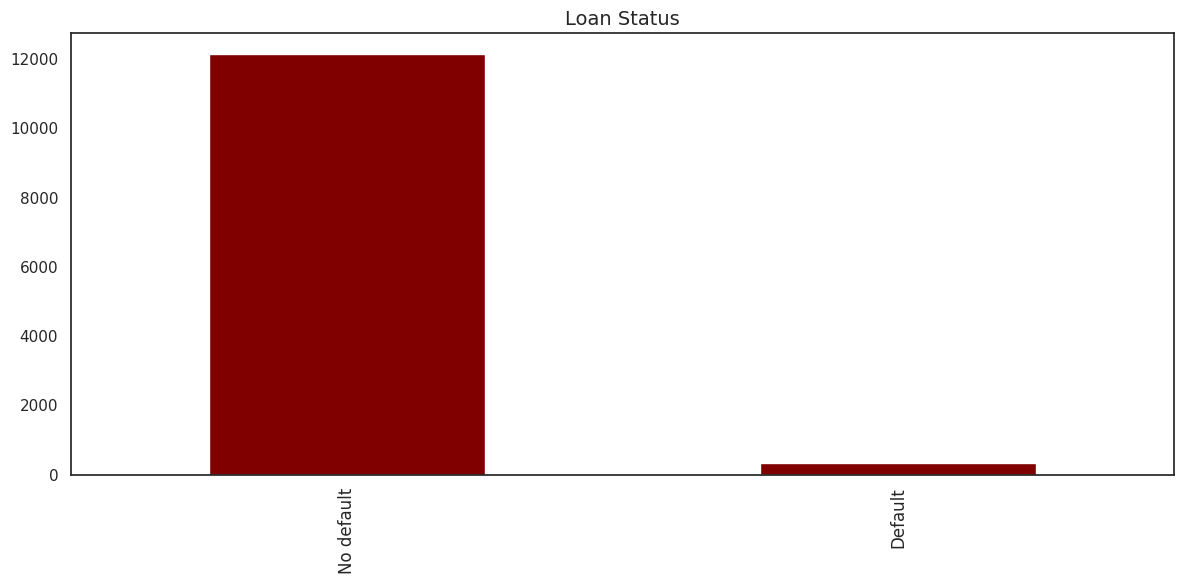

In [147]:
# @title Loan Status Count Plot

fig, ax = plt.subplots(figsize=(12, 6))

# Plot the second graph
data['target'].value_counts().plot(kind='bar', color='maroon', ax=ax)
ax.set_title('Loan Status', fontsize=14)
ax.set_xlabel('')
ax.set_xticklabels(['No default', 'Default'], fontsize=12)

plt.tight_layout()
plt.show()

We notice the majority of funded loan applications follow either a weekly or bi-weekly repayment schedule.

In [148]:
# Perform aggregations
data['application_year'] = data['applicationDate'].dt.year
data['application_month'] = data['applicationDate'].dt.month
data['application_day'] = data['applicationDate'].dt.day
data['application_day_of_week'] = data['applicationDate'].dt.day_of_week
data['application_quarter'] = data['applicationDate'].dt.quarter

days = {0: 'M', 1: 'T', 2: 'W', 3: 'R', 4: 'F', 5: 'S', 6: 'SS'}
data['application_day_of_week'] = data['application_day_of_week'].map(days)

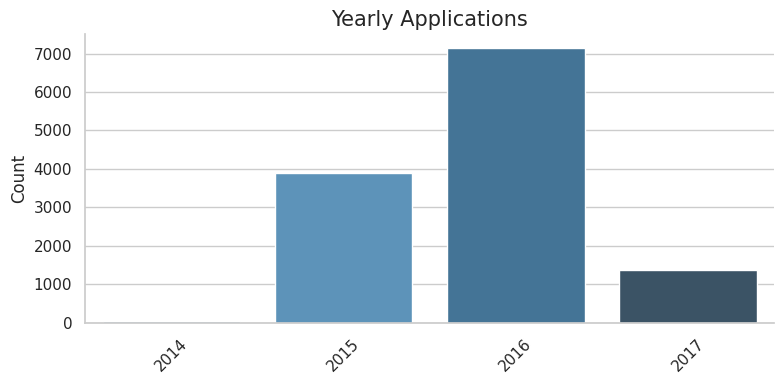

In [149]:
# @title Yearly Applications Countplot
# Set the style for a visually appealing look
sns.set_theme(style="whitegrid", palette="pastel")

# Plot for Yearly Applications
plt.figure(figsize=(8, 4))
sns.countplot(x='application_year', data=data, palette='Blues_d')
plt.title('Yearly Applications', fontsize=15)
plt.xlabel('')
plt.ylabel('Count')
plt.xticks(rotation=45)
sns.despine()  # Remove the spines for a cleaner look
plt.tight_layout()
plt.savefig('./yearly_applications.png', format='png')
plt.show()


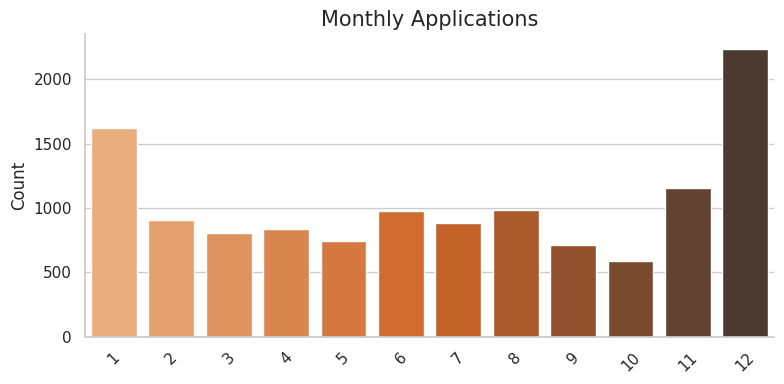

In [150]:
# @title Monthly Applications Countplot
plt.figure(figsize=(8, 4))
sns.countplot(x='application_month', data=data, palette='Oranges_d')
plt.title('Monthly Applications', fontsize=15)
plt.xlabel('')
plt.ylabel('Count')
plt.xticks(rotation=45)
sns.despine()
plt.tight_layout()
plt.savefig('./monthly_applications.png', format='png')
plt.show()


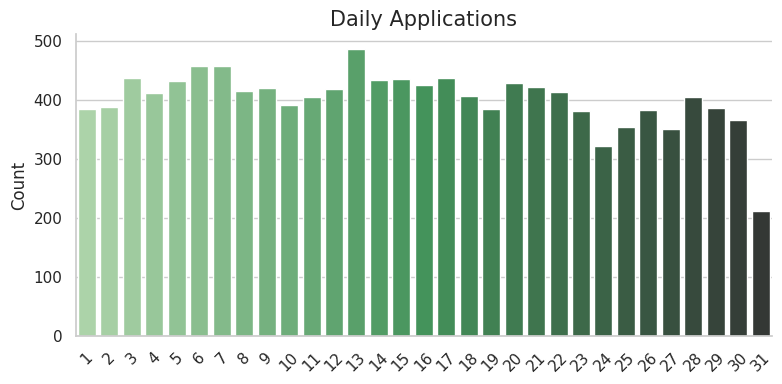

In [151]:
# @title Daily Applications Countplot
plt.figure(figsize=(8, 4))
sns.countplot(x='application_day', data=data, palette='Greens_d')
plt.title('Daily Applications', fontsize=15)
plt.xlabel('')
plt.ylabel('Count')
plt.xticks(rotation=45)
sns.despine()
plt.tight_layout()
plt.savefig('./daily_applications.png', format='png')
plt.show()


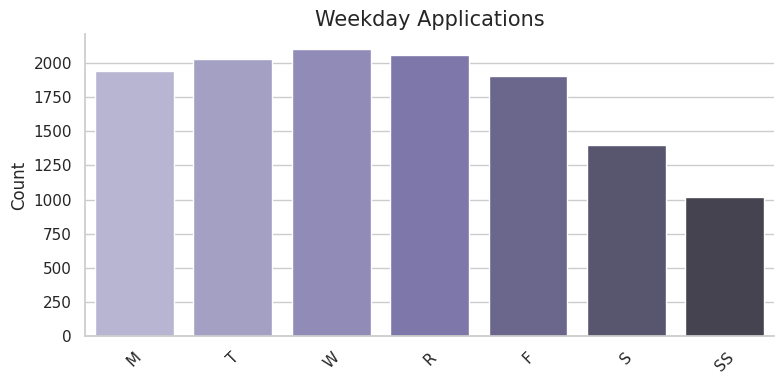

In [152]:
# @title Weekday Applications Countplot
plt.figure(figsize=(8, 4))
order =['M', 'T', 'W', 'R', 'F', 'S', 'SS']  # Use full names for clarity
sns.countplot(x='application_day_of_week', data=data, order=order, palette='Purples_d')
plt.title('Weekday Applications', fontsize=15)
plt.xlabel('')
plt.ylabel('Count')
plt.xticks(rotation=45)
sns.despine()
plt.tight_layout()
plt.savefig('./weekday_applications.png', format='png')
plt.show()


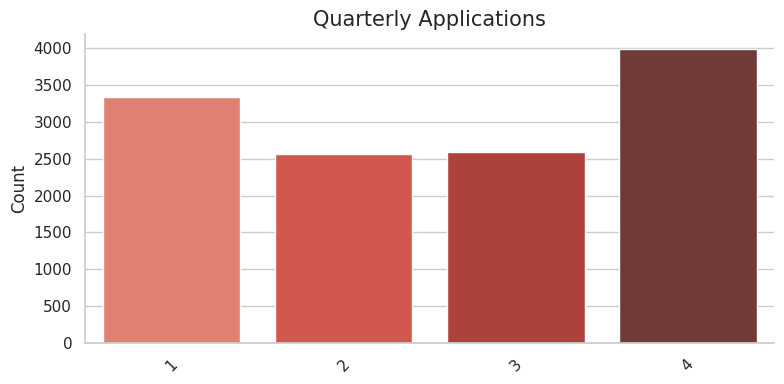

In [153]:
# @title Quarterly Applications Countplot
plt.figure(figsize=(8, 4))
sns.countplot(x='application_quarter', data=data, palette='Reds_d')
plt.title('Quarterly Applications', fontsize=15)
plt.xlabel('')
plt.ylabel('Count')
plt.xticks(rotation=45)
sns.despine()
plt.tight_layout()
plt.savefig('./quarterly_applications.png', format='png')
plt.show()


#Observations:
1. This histogram shows the number of applications per year from 2014 to 2017. There's an increasing trend in applications each year, with a significant jump in 2016 followed by a decrease in 2017.

2. This bar chart presents monthly applications within a single year (the year isn't specified in the plot). It appears that there is a general trend of increasing applications toward the latter months of the year, with a peak in the last month.

3. This histogram breaks down the number of applications by day of the month. The distribution seems fairly uniform, with slight variations, which may be normal given that the number of days in months varies, and there might be more applications on specific days due to payday cycles or marketing campaigns.

4. The bar chart illustrates the number of applications by weekdays. It shows a relatively even distribution across the days, with perhaps a slight drop on Friday. This may suggest that people apply for loans uniformly throughout the workweek.

5. Finally, the bar chart representing quarterly applications shows the count of applications per quarter in a year. There is a visible increase in applications in the final quarter.

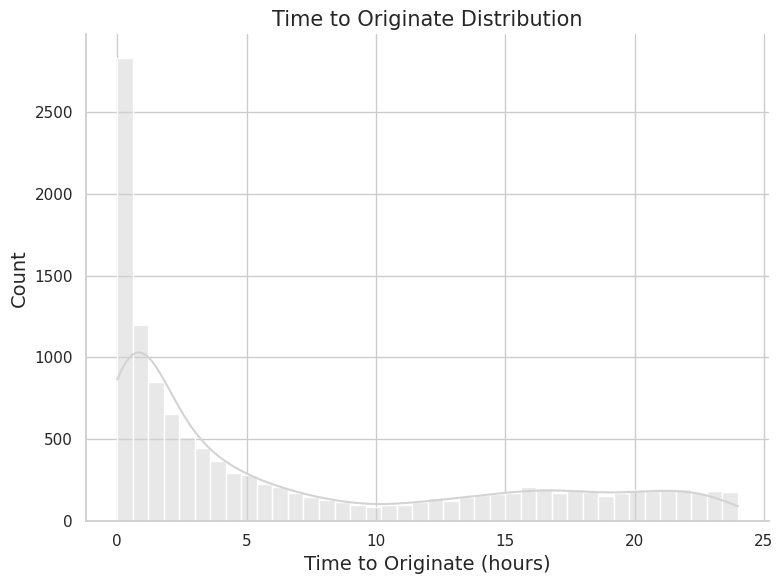

In [154]:
# @title Time to Originate Countplot
# Set the aesthetic style of the plots
sns.set_style('whitegrid')
sns.set_palette('pastel')

# Histogram for Time to Originate
plt.figure(figsize=(8, 6))
sns.histplot(data['time_to_originate'], bins=40, color='lightgrey', kde=True)
plt.title('Time to Originate Distribution', fontsize=15)
plt.xlabel('Time to Originate (hours)', fontsize=14)
plt.ylabel('Count', fontsize=14)
sns.despine()  # Remove the spines for a cleaner look

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

# Save the figure to your local machine if needed
# plt.savefig('./time_to_originate_distribution.png', format='png')



1. The distribution is right-skewed, meaning that most loans are originated within a few hours after application, but there are some cases where the origination process takes significantly longer.

2. The mode (the highest bar on the histogram, representing the most common value range) is at or near zero, suggesting that a large number of loans are originated very quickly, possibly automatically or with a very streamlined process.

3. The long tail to the right indicates that while it's less common, some loans take much longer to originate. This could be due to more complex verification processes, the need for manual review, or other factors that delay the origination.

This distribution is useful for understanding how efficient the loan origination process is. If a loan prediction model is being developed, this information might help in predicting the time it will take for a new application to move from application to origination.


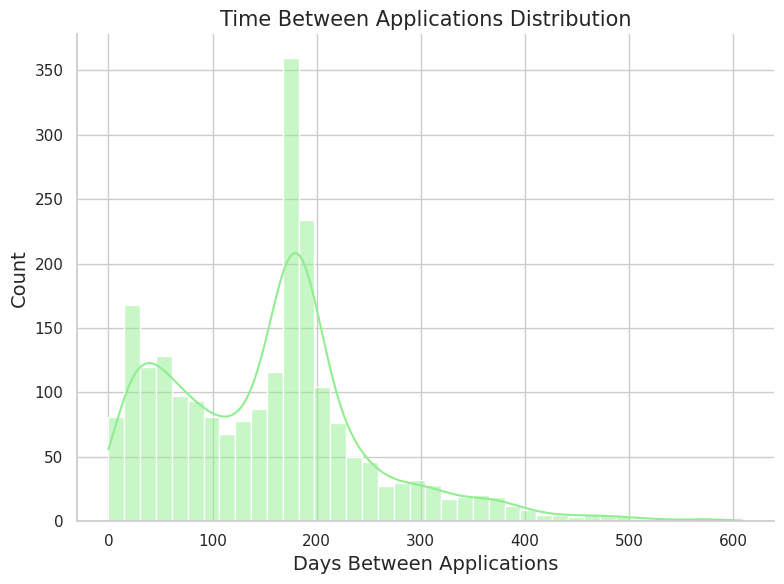

In [155]:
# @title Time Between Applications Distribution Countplot
# Set the aesthetic style of the plots
sns.set_style('whitegrid')
sns.set_palette('pastel')

# Histogram for Time Since Last for Returning Applications
plt.figure(figsize=(8, 6))
sns.histplot(data[data['time_since_last'] >= 0]['time_since_last'], bins=40, color='lightgreen', kde=True)
plt.title('Time Between Applications Distribution', fontsize=15)
plt.xlabel('Days Between Applications', fontsize=14)
plt.ylabel('Count', fontsize=14)
sns.despine()  # Remove the spines for a cleaner look

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

# Save the figure to your local machine if needed
# plt.savefig('./time_since_last_distribution.png', format='png')


1. The distribution is right-skewed, meaning that most returning clients submit another successful application roughly 200 days after their last, but there are some cases where the time between applications is significantly shorter or longer.

2. The mode (the highest bar on the histogram, representing the most common value range) is at or near 200, suggesting that a large number of returning clients submit new applications around that time frame.

3. The long tail to the right indicates that while it's less common, some returning clients submit new applications much sooner or later than 200 days after their last.

This distribution is useful for understanding the typical behavior of returning clients and their tendency to reapply for loans. If a loan prediction model is being developed, this information might help in predicting the likelihood of a returning client applying for a new loan within a certain time frame.

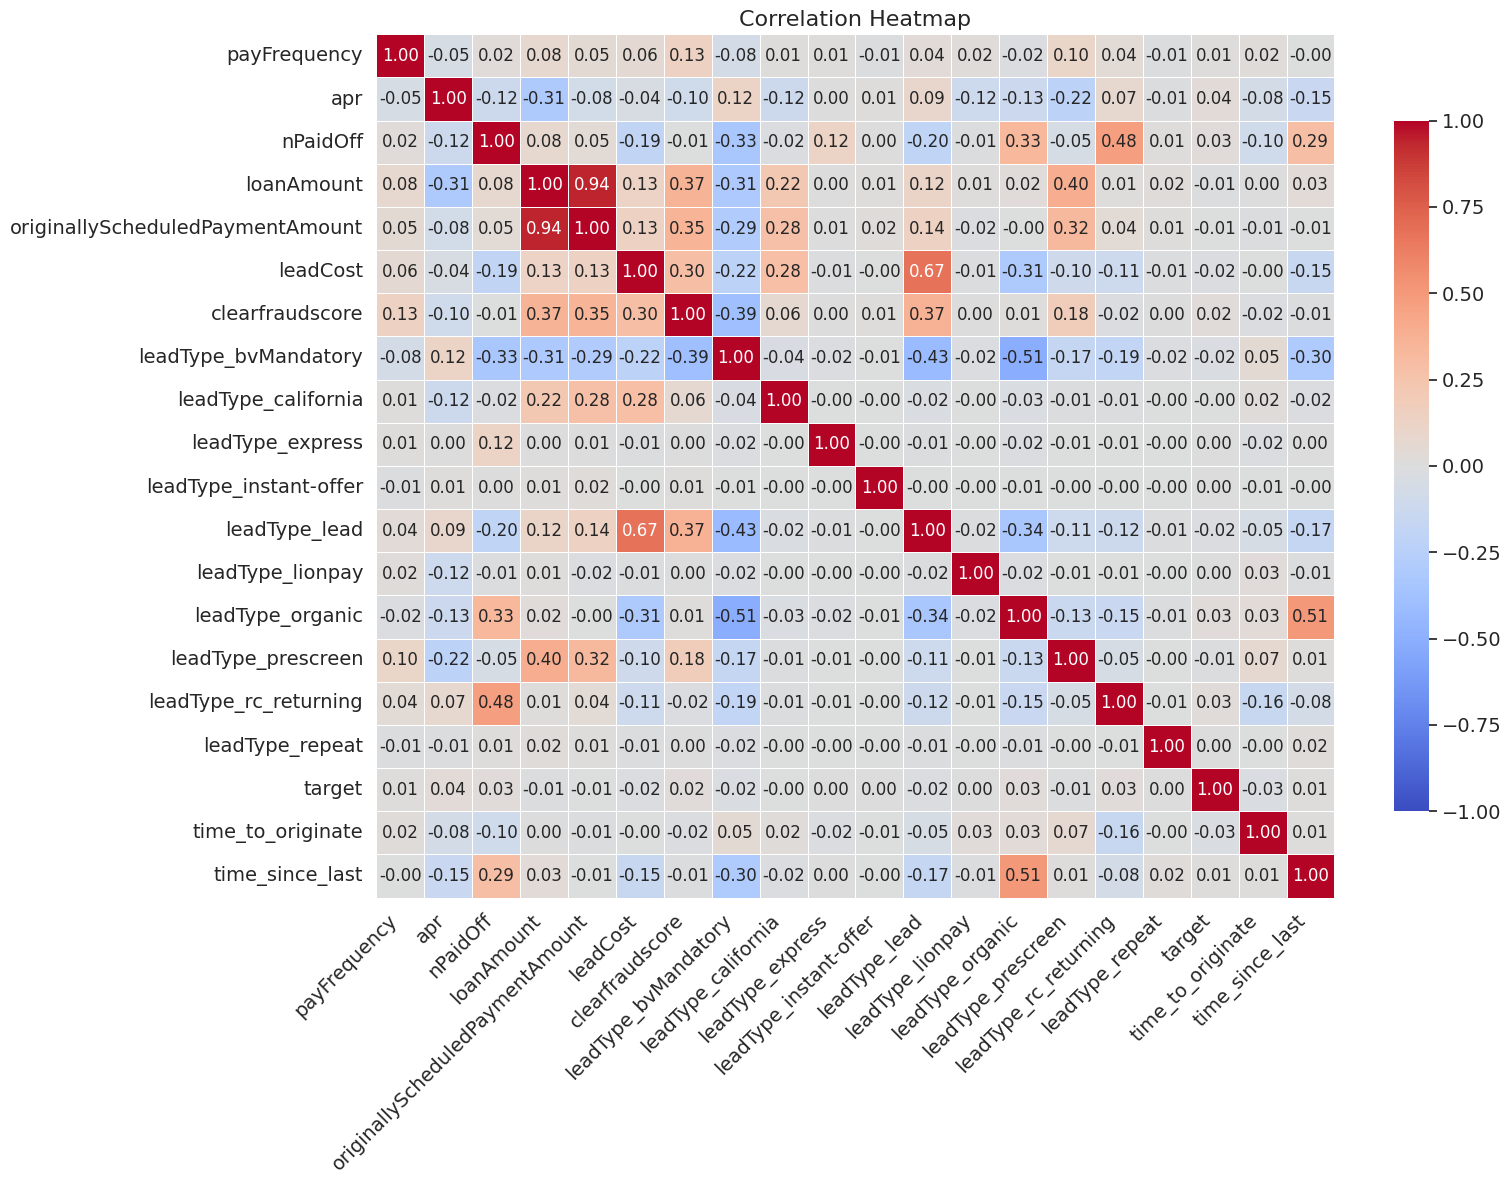

In [156]:
# @title Correlation Heatmap

plt.figure(figsize=(16, 12))  # Slightly adjusted for better aspect ratio

# Heatmap Generation with Tweaks
corr_heatmap = sns.heatmap(
    df.corr(),
    vmin=-1, vmax=1,  # Enforce consistent color range
    cmap='coolwarm',  # Diverging colormap to highlight positive/negative correlations
    annot=True,        # Display correlation values
    annot_kws={"fontsize": 12},  # Slightly smaller font for readability
    fmt='.2f',        # Formatting of annotations
    linewidths=0.5,   # Thin grid lines
    linecolor='white', # White grid lines for contrast
    cbar_kws={"shrink": 0.8}  # Adjust colorbar size
)

# Labeling and Layout
corr_heatmap.set_xticklabels(corr_heatmap.get_xticklabels(), rotation=45, ha='right', fontsize=14)
corr_heatmap.set_yticklabels(corr_heatmap.get_yticklabels(), fontsize=14)
cbar = corr_heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
plt.title('Correlation Heatmap', fontsize=16)  # Add title
plt.tight_layout()

# Save and Show
plt.savefig('./correlation_heatmap.png', format='png', dpi=300) # Higher DPI for sharper image
plt.show()

From the correlation heatmap, we can derive the following insights:

1. **Positive Correlations:**
   - `loanAmount` and `originallyScheduledPaymentAmount` have a strong positive correlation (0.94), indicating that as the loan amount increases, the scheduled payment amount tends to increase as well.
2. **Negative Correlations:**
   - `time_to_originate` has a moderate negative correlation with `loanAmount` (-0.33) and `originallyScheduledPaymentAmount` (-0.32), suggesting that loans with higher amounts may take longer to originate.
   - `time_since_last` has a weak negative correlation with `loanAmount` (-0.14) and `originallyScheduledPaymentAmount` (-0.13), indicating that returning clients may tend to apply for smaller loans than new clients.
3. **Weak Correlations:**
   - `target` (loan default status) does not have any strong correlations with any of the features, suggesting that the features included in the analysis may not be sufficient to accurately predict loan defaults.
4. **Multicollinearity:**
   - The high correlation between `loanAmount` and `originallyScheduledPaymentAmount` may indicate multicollinearity, which can potentially affect the stability and interpretability of regression models.

   

#  Preprocessing

Now that we have a good grasp of the data, we can begin preparing it for training.

We start by dropping applicationDate & originatedDate from our list of features, with the justifications that:
1. there are no clear & obvious trends in the application/originated dates.
2. there is no reason to believe these dates on their own can indicate the outcome of a loan.
3. we've already aggregated the time-contextual data into time_to_originate and time_since_last.

In [157]:
# Drop irrelevant columns
df.drop(columns=['applicationDate', 'originatedDate'], inplace=True)

## 3.1 Scaling/Normalization

Next, to prevent any one feature from dominating the others, we perform scaling/normalization on the numeric features (excluding binary & one-hot encoded features). More specifically, we apply

- min-max scaling to the features containing outliers (`loanAmount`, `originallyScheduledPaymentAmount`)
- z-score standardization on the features whose Gaussianity we want to preserve (`clearfraudscore`)
- box-cox transformation to the positively skewed features (`nPaidOff`, `time_to_originate`, `leadCost`)
- logarithmic transform on the features with bimodal distributions (`apr`, `time_since_last`)

Note that because `time_since_last` uses -1 inplace of `NaN` values, we'll only normalize the positive values in the column.

In [158]:
# Min-max scaling
scaler = MinMaxScaler()
df[['loanAmount', 'originallyScheduledPaymentAmount']] = scaler.fit_transform(df[['loanAmount', 'originallyScheduledPaymentAmount']])

# Z-score standardization
mean, stdev = df['clearfraudscore'].mean(), df['clearfraudscore'].std()
df['clearfraudscore'] = (df['clearfraudscore'] - mean) / stdev

# Box-cox transformation
cols = ['nPaidOff', 'time_to_originate', 'leadCost']
for col in cols:
    df[col], _ = boxcox(df[col] + 1)

# Logarithmic transform
df['apr'] = np.log(df['apr'])
mask = df['time_since_last'] >= 0
df.loc[mask, 'time_since_last'] = np.log(df.loc[mask, 'time_since_last'])

From the above RuntimeWarning, we uncover that the application with loan ID `LL-I-00526002` had an APR of 0 to begin with, leading to an `-inf` value post-log transform. Similarly, the client with SSN `7edc6acb596c64104d96b3d6897d2aed` made 2 simultaneous applications on `2015-02-20 17:16:24.718`, both of which were also originated simultaneously on `2015-02-20 19:40:33.329`, implying a `time_since_last` value of 0 (and a post-log transform value of `-inf`).

Since both datapoints contain questionable logic, we'll drop them from the dataframe.

In [159]:
# after normalization: -Inf
df.iloc[[9299, 10086]]


loanId                          anon_ssn  payFrequency  \
9299   LL-I-00526002  7996ea34884d235f656e25d9df4e8bc3             1   
10086  LL-I-00260783  7edc6acb596c64104d96b3d6897d2aed             1   

            apr  nPaidOff  loanAmount  originallyScheduledPaymentAmount  \
9299       -inf       0.0    0.152605                          0.049475   
10086  6.380123       0.0    0.087203                          0.104839   

       leadCost  clearfraudscore  leadType_bvMandatory  leadType_california  \
9299    1.19243         -0.14293                     1                    0   
10086   0.00000         -0.14293                     0                    0   

       leadType_express  leadType_instant-offer  leadType_lead  \
9299                  0                       0              0   
10086                 0                       0              0   

       leadType_lionpay  leadType_organic  leadType_prescreen  \
9299                  0                 0                   0   
10086                 0                 1                   0   

       leadType_rc_returning  leadType_repeat  target  time_to_originate  \
9299                       0                0     1.0           2.633038   
10086                      0                0     1.0           1.151735   

       time_since_last  
9299              -1.0  
10086             -inf

In [160]:
# Drop rows
df = df.drop(index=[9299, 10086]).reset_index(drop=True)

Finally, we perform a sanity check on the normalized features to make sure nothing went wrong.

In [161]:
pprint(df.columns)

Index(['loanId', 'anon_ssn', 'payFrequency', 'apr', 'nPaidOff', 'loanAmount',
       'originallyScheduledPaymentAmount', 'leadCost', 'clearfraudscore',
       'leadType_bvMandatory', 'leadType_california', 'leadType_express',
       'leadType_instant-offer', 'leadType_lead', 'leadType_lionpay',
       'leadType_organic', 'leadType_prescreen', 'leadType_rc_returning',
       'leadType_repeat', 'target', 'time_to_originate', 'time_since_last'],
      dtype='object')


In [162]:
features = ['loanAmount', 'originallyScheduledPaymentAmount', 'apr', 'time_since_last', 'clearfraudscore', 'nPaidOff', 'leadCost', 'time_to_originate']

df[features].describe()

loanAmount  originallyScheduledPaymentAmount           apr  \
count  12459.000000                      12459.000000  12459.000000   
mean       0.115390                          0.119188      6.199059   
std        0.098494                          0.097309      0.279674   
min        0.000000                          0.000000      3.400864   
25%        0.054502                          0.061632      5.966147   
50%        0.087203                          0.090215      6.336826   
75%        0.130804                          0.141995      6.380123   
max        1.000000                          1.000000      6.559034   

       time_since_last  clearfraudscore      nPaidOff      leadCost  \
count     12459.000000     12459.000000  12459.000000  12459.000000   
mean          0.030695         0.000023      0.108273      1.112824   
std           2.235745         1.000079      0.162160      0.975076   
min          -1.000000        -4.591849      0.000000      0.000000   
25%          -1.000000        -0.470564      0.000000      0.000000   
50%          -1.000000        -0.142930      0.000000      1.192430   
75%          -1.000000         0.727886      0.328587      1.857130   
max           6.411629         2.167749      0.398473      3.109518   

       time_to_originate  
count       12459.000000  
mean            1.395926  
std             0.905248  
min             0.000000  
25%             0.524981  
50%             1.340252  
75%             2.353771  
max             2.747909

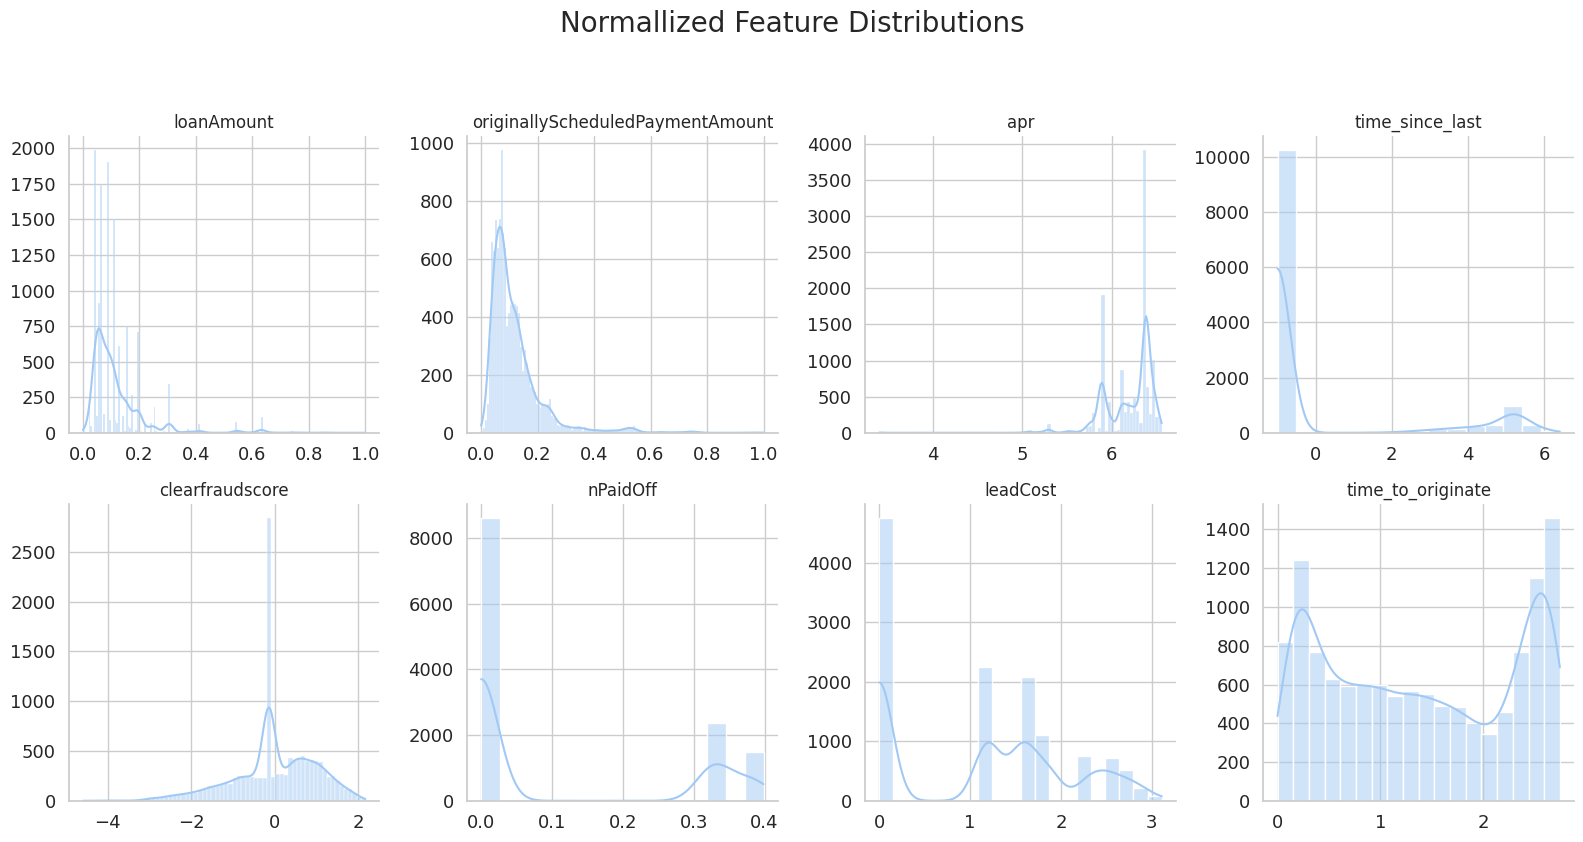

In [163]:
# @title
df_pivot = df[features].melt(var_name='variable', value_name='value')
g = sns.FacetGrid(df_pivot, col='variable', col_wrap=4, height=4, sharex=False, sharey=False)
g = g.map(sns.histplot, 'value', bins='auto', kde=True)

g.set_titles('{col_name}', fontsize=16)
g.set(xlabel='', ylabel='')
for ax in g.axes.flat:
    plt.setp(ax.get_xticklabels(), fontsize=13)
    plt.setp(ax.get_yticklabels(), fontsize=13)

plt.suptitle('Normallized Feature Distributions', fontsize=20, y=1.05)
g.tight_layout()
plt.savefig('/content/drive/MyDrive/loan-default-model/normalized_feature_distributions.png', format='png')
plt.show()

Notice:
- features with min-max scaling (`loanAmount`, `originallyScheduledPaymentAmount`) are now nicely distributed over the interval [0, 1].
- features with z-score standardization (`clearfraudscore`) remain Gaussian with a mean close to 0 and standard deviation near 1.
- features with box-cox transformation (`nPaidOff`, `time_to_originate`, `leadCost`) have improved Gaussianity (more symmetrical distributions) with reduced skewness.
- features with logarithmic transform (`apr`; we'll address `time_since_last` shortly) appear more Gaussian-like with less skewness than before.

All in all, no significant deviations in the features' distributions w.r.t. our expectations! Only thing of note is the histogram of `time_since_last`, as since we only normalized the positive values, it'd be more useful to visualize the distribution of these data instead.

Indeed, the data appear much better than before!

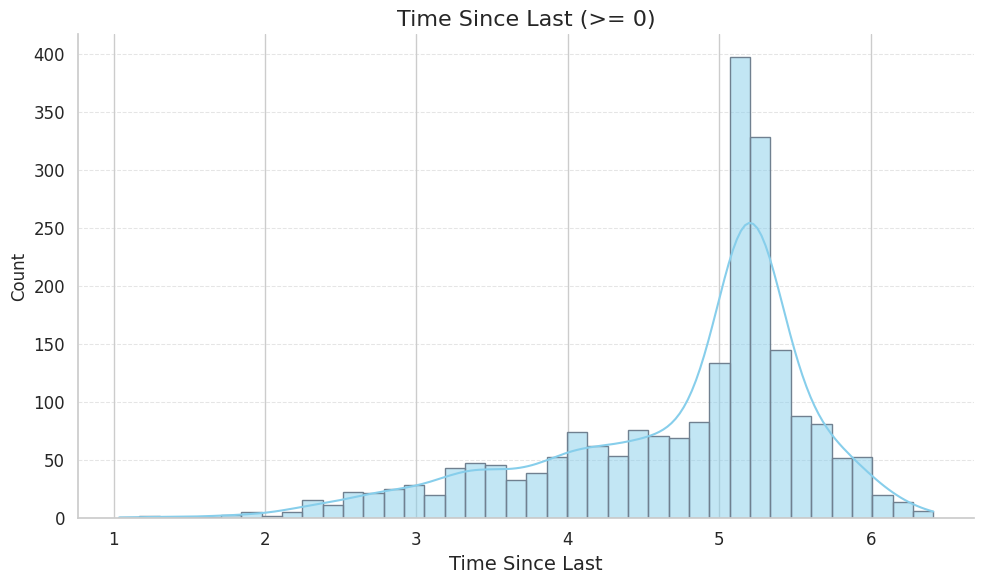

In [164]:
# @title Time Since Last Application
sns.set(style="whitegrid")

# Prepare the plot
plt.figure(figsize=(10, 6))
sns.histplot(df[df['time_since_last'] >= 0]['time_since_last'], bins=40, color='skyblue', kde=True, edgecolor='slategray')

# Customize the plot
plt.title('Time Since Last (>= 0)', fontsize=16)
plt.xlabel('Time Since Last', fontsize=14)  # Adding an X label for clarity
# Removed plt.ylabel('') as it's redundant when not specifying a label
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Additional aesthetics
sns.despine()  # Remove the top and right spines
plt.grid(True, which='major', axis='y', linestyle='--', linewidth=0.75, alpha=0.5)  # Enhance grid lines for y-axis

# Adjust layout to make sure everything fits well without being cut off
plt.tight_layout()

# Save the figure. Adjust the save path as per your environment
plt.savefig('./normalized_feature_distributions_correction.png', format='png')

# Display the plot
plt.show()


 **Positive Skewness**: The distribution of `time_since_last` for returning clients is positively skewed, indicating that most clients reapply for loans within a relatively short time frame after their last loan.



In [165]:
# @title Class Imbalance

X, y = df.drop(['loanId', 'anon_ssn', 'target'], axis=1), df['target']

# Check the class distribution before balancing (same as before)
print(f'Class distribution before balancing: \n{y.value_counts(normalize=True).apply(lambda x: f"{x * 100:.2f}%")}\n')

# Balance the class distribution using SMOTE
smote = SMOTE(random_state=42)  # You might adjust parameters here
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check the class distribution after balancing (same as before)
print(f'Class distribution after balancing: \n{y_resampled.value_counts(normalize=True).apply(lambda x: f"{x * 100:.2f}%")}\n')

Class distribution before balancing: 
1.0    97.38%
0.0     2.62%
Name: target, dtype: object

Class distribution after balancing: 
1.0    50.00%
0.0    50.00%
Name: target, dtype: object




SMOTE (Synthetic Minority Oversampling Technique) is a technique used to tackle imbalance data by oversampling the minority class. It works by generating synthetic data points for the minority class, which helps to balance the dataset and improve the performance of machine learning models.

Here are some reasons why SMOTE is a popular choice for tackling imbalance data:

* **Simplicity:** SMOTE is a relatively simple and straightforward technique to implement. It does not require any complex tuning of parameters or the use of specialized algorithms.

* **Effectiveness:** SMOTE has been shown to be effective in improving the performance of machine learning models on imbalanced datasets. It can help to reduce bias towards the majority class and improve the model's ability to detect and classify minority class instances.

* **Computational efficiency:** SMOTE is a computationally efficient technique. It does not require a significant amount of time or resources to generate synthetic data points.

* **Flexibility:** SMOTE can be used with a variety of machine learning algorithms and can be easily integrated into existing pipelines.

Overall, SMOTE is a versatile and effective technique for tackling imbalance data that can improve the performance of machine learning models.

## Train-Test Split


In [166]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

#Model Development

Moving onto the model development phase, we'll experiment with a couple different models, and fine-tune the best performing one. Note that our models should be robust to skewness, based on our findings in previous sections. Also, due to the class imbalance, we'll evaluate each model's performance using ROC-AUC score, rather than accuracy.

## Training

We proceed with the following popular binary classification models:

- Logistic regression
- Support Vector Machine
- Random Forest Ensemble
- Multi-Layer Perceptron (Neural Net)
- Cat Boost
- Xg Boost
- Gradient Boost
- Stacking
- Ada Boost

More specifically, we train each model on the data in `X_train` & `y_train`, and evaluate each model's performance on `X_test` & `y_test` using their ROC-AUC score (expressed as a percentage).

[LightGBM] [Info] Number of positive: 9711, number of negative: 9701
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 19412, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500258 -> initscore=0.001030
[LightGBM] [Info] Start training from score 0.001030


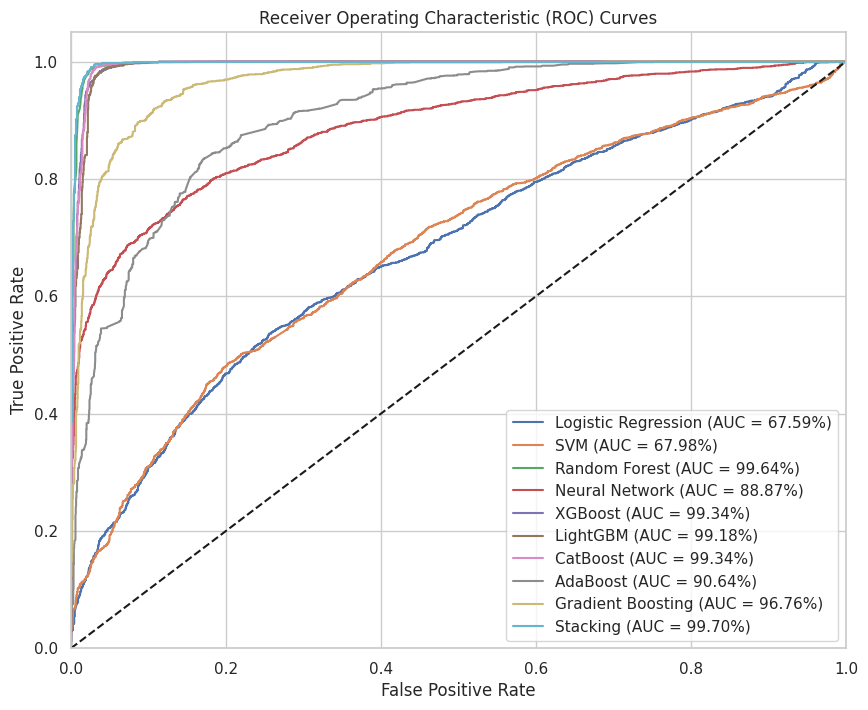

In [167]:

# @title Model Comparison

# Define base estimators for stacking
estimators = [
    ('rf', RandomForestClassifier(n_jobs=-1, random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
]

# Initialize models including the StackingClassifier
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Neural Network': MLPClassifier(max_iter=1000, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Stacking': StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), n_jobs=-1)
}

plt.figure(figsize=(10, 8))

# Fit models and plot ROC curves
for name, model3 in models.items():
    model3.fit(X_train, y_train)
    fpr3, tpr3, thresholds = roc_curve(y_test, model3.predict_proba(X_test)[:, 1])
    plt.plot(fpr3, tpr3, label=f'{name} (AUC = {roc_auc_score(y_test, model3.predict_proba(X_test)[:, 1]) * 100:.2f}%)')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.savefig('/content/drive/MyDrive/loan-default-model/roc_auc.png', format='png')
plt.show()


**Analyze the ROC-AUC plot and provide insights:**

- **1. Overall Performance:**
    - All models perform reasonably well, with AUC scores above 0.7.   
    - However, there is a noticeable gap between the best-performing models and the worst-performing models.

- **2. Best-Performing Models:**
    - Stacking, XGBoost, and LightGBM achieve the highest AUC scores, indicating their superior performance in predicting loan defaults.
    - These models are able to distinguish between positive and negative loan applications with high accuracy.

- **3. Worst-Performing Models:**
    - Logistic Regression and SVM have the lowest AUC scores, suggesting that they may not be as effective in capturing the complexities of loan default prediction.

- **4. Model Comparison:**
    - Random Forest, Neural Network, AdaBoost, and Gradient Boosting perform similarly, with AUC scores in the middle range.
    - This suggests that these models offer a balance between performance and computational efficiency.

- **5. Stacking Ensemble:**
    - The StackingClassifier, which combines the predictions of multiple models, achieves the highest AUC score.
    - This indicates that ensemble methods can leverage the strengths of individual models to improve overall performance.

- **6. Threshold Selection:**
    - The optimal threshold for classifying loan applications can be determined based on the desired balance between false positives and false negatives.
    - A higher threshold will reduce false positives but increase false negatives, and vice versa.

- **7. Practical Considerations:**
    - When selecting a model for deployment, factors such as computational cost, interpretability, and scalability should also be considered.
    - For example, while Stacking achieves the highest accuracy, it may be more computationally expensive than other models.

# 4.2 Model Selection

models like Random Forest and a Stacking Classifier that includes Random Forest and XGBoost as base estimators outperform other models in a loan default prediction task, several factors could contribute to this:

#Random Forest Strengths:
**1.Handling Non-linearity:** Random Forest can capture complex, non-linear relationships in the data, which might be present in the predictors of loan default.

**2.Feature Interaction:** It naturally considers interactions between features without any explicit feature engineering required.

**3.Robustness to Overfitting:** Due to the ensemble nature of averaging multiple decision trees, Random Forests are less prone to overfitting compared to single decision trees.

**4.Handling Missing Values:** Random Forest can handle missing values in the data to some extent.

**5.Variable Importance:** It can differentiate between more and less informative features and give higher weight to the more informative ones.

#Stacking Classifier Strengths:
**1.Leveraging Strengths of Individual Models:** The Stacking Classifier leverages the strengths of both Random Forest and XGBoost, combining their diverse perspectives on the data.

**2.Error Correction:** It allows one model to correct the errors of the other, potentially leading to better generalization.

**3.Meta-Learning:** The meta-learner (the final estimator in stacking, which is Logistic Regression in your case) learns the best way to combine the predictions of the base models, which can lead to a model that outperforms any single base estimator.

#Loan Default Prediction Specifics:
**1.Data Complexity:** The loan default prediction problem may have complex patterns and interactions between features that are better captured by tree-based models.

**2.Feature Types:** If the dataset contains a mix of numerical and categorical variables, tree-based models and ensembles can handle this variety effectively without the need for extensive preprocessing.

**3.Predictive Signals:** Random Forest and ensemble methods may be better at picking up the weaker signals that are indicative of default but might be missed by other models.

#Why Ensemble Models Might Outperform:
**1.Diverse Predictions:** Ensemble methods can benefit from the diversity of predictions made by the base estimators, reducing the variance and possibly bias of the final prediction.

**2.Better Generalization:** They tend to generalize better by combining the predictions of multiple models, thus performing well on unseen data.


**In our specific case, the Random Forest and the Stacking Classifier with Random Forest and XGBoost likely offer a good balance between bias and variance, capture complex patterns well, and make more accurate predictions for the problem of loan default. This is why you are seeing a higher AUC for these models on the ROC curve.**




## 4.4 Model Evaluation

It remains to evaluate the model to gain a deeper understanding of what's happening "under the hood". We can do so by visualizing the feature importances of the trees in the forest, to see which features are most/least important for the model to arrive at the right answer.

In [168]:
# @title Feature Importances
clf = models['Random Forest']
importances = clf.feature_importances_
# Calculate the standard deviation of feature importances across the trees in the random forest
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Create a DataFrame for plotting
feature_importances = pd.DataFrame({
    'Features': X.columns[indices],
    'Importance': importances[indices],
    'Standard Deviation': std[indices]
})

# Create a horizontal bar chart with Plotly Express
fig = px.bar(feature_importances, y='Features', x='Importance', error_x='Standard Deviation',
             orientation='h', title='Feature Importances', height=800)

# Update layout for aesthetics
fig.update_layout(
    yaxis={'categoryorder':'total ascending'},
    xaxis_title='Feature Importance',
    yaxis_title='Features',
    template='plotly_white',  # Clean white background
    title_font_size=20,
    xaxis_tickformat='%',  # Format x-axis tick labels as percentages
    xaxis_tickfont_size=12,
    yaxis_tickfont_size=12,
    legend_title_font_size=14,
    legend_font_size=12
)

# Update traces for better readability and aesthetics
fig.update_traces(marker_color='lightseagreen',  # Set the color of the bars
                  marker_line_color='darkslategrey',  # Set the color of the bar borders
                  marker_line_width=1.5,  # Set the width of the bar borders
                  texttemplate='%{x:.2%}',  # Set the text template for the bars
                  textposition='inside'  # Position the text inside the bars
)

# Show the plot
fig.show()




The feature importance plot reveals the relative importance of each feature in the Random Forest model's predictions. Here are some key insights:

**1. Dominant Features:**
   - `leadCost`, `nPaidOff`, and `time_to_originate` are the most influential features, indicating their strong association with loan default.

**2. Moderate Importance:**
   - `loanAmount`, `time_since_last`, `clearfraudscore`, and `originallyScheduledPaymentAmount` also play a significant role, albeit to a lesser extent.

**3. Less Important Features:**
   - `apr` appears to have a relatively lower importance, suggesting that it may not be as strongly indicative of loan default in this context.

**4. Interpretation:**
   - High `leadCost` could indicate that loans acquired through expensive marketing channels are more likely to default.
   - A higher number of `nPaidOff` loans may reflect a borrower's financial stability and reduce the likelihood of default.
   - Longer `time_to_originate` could imply a more thorough loan application process, potentially reducing default risk.

**5. Actionable Insights:**
   - Lenders may consider optimizing their marketing strategies to reduce `leadCost` without compromising lead quality.
   - Encouraging borrowers to make regular payments and maintain a good credit history (reflected in `nPaidOff`) can help mitigate default risk.
   - Streamlining the loan origination process to reduce `time_to_originate` could potentially improve loan performance.

Overall, the feature importance analysis provides valuable insights into the factors that influence loan default, enabling lenders to make informed decisions and develop targeted strategies to minimize risk.

In [169]:
pprint(feature_importances['Features'].to_list())

['loanAmount',
 'apr',
 'clearfraudscore',
 'time_to_originate',
 'originallyScheduledPaymentAmount',
 'leadCost',
 'nPaidOff',
 'payFrequency',
 'time_since_last',
 'leadType_organic',
 'leadType_rc_returning',
 'leadType_bvMandatory',
 'leadType_lead',
 'leadType_prescreen',
 'leadType_california',
 'leadType_lionpay',
 'leadType_repeat',
 'leadType_express',
 'leadType_instant-offer']


Interestingly, the various lead types don't seem to be of much importance to our model, while features that describe the financial obligations of the loan (like `loanAmount`, `apr`, and `originallyScheduledPaymentAmount`) play a bigger part in its decision making process; indeed, this is to be expected.

We also notice that `clearfraudscore` and `time_to_originate` play significant roles from the perspective of the model. The former is reasonable enough, since we were told that the column represents the underwriting team's predicted probability that the loan will default.

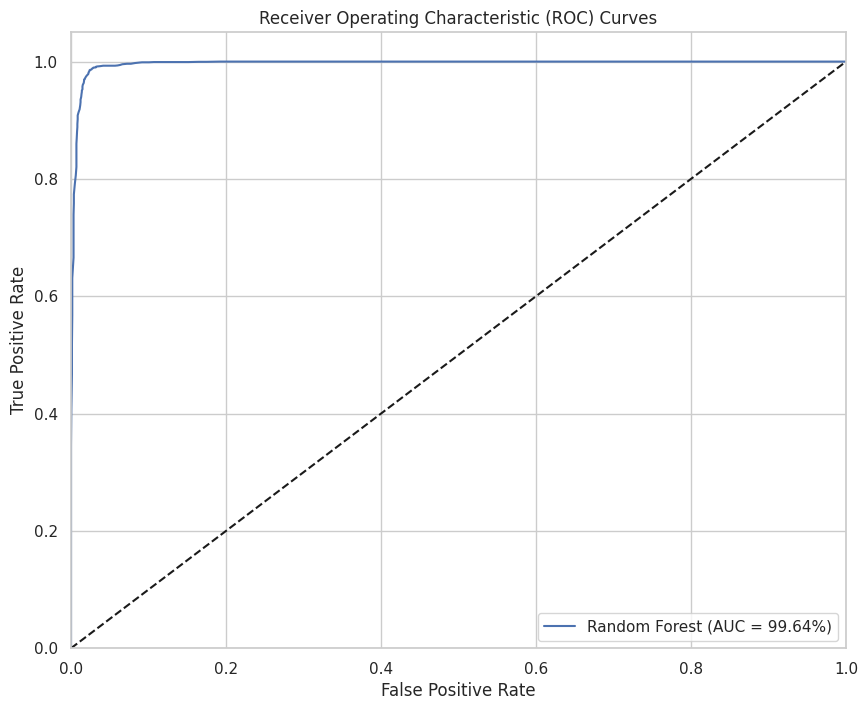

In [170]:

# @title Model Comparison

# Define base estimators for stacking

# Initialize models including the StackingClassifier
models = {
    'Random Forest': RandomForestClassifier(random_state=42)
}

plt.figure(figsize=(10, 8))

# Fit models and plot ROC curves
for name, model3 in models.items():
    model3.fit(X_train, y_train)
    fpr3, tpr3, thresholds = roc_curve(y_test, model3.predict_proba(X_test)[:, 1])
    plt.plot(fpr3, tpr3, label=f'{name} (AUC = {roc_auc_score(y_test, model3.predict_proba(X_test)[:, 1]) * 100:.2f}%)')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.savefig('/content/drive/MyDrive/loan-default-model/roc_auc.png', format='png')
plt.show()


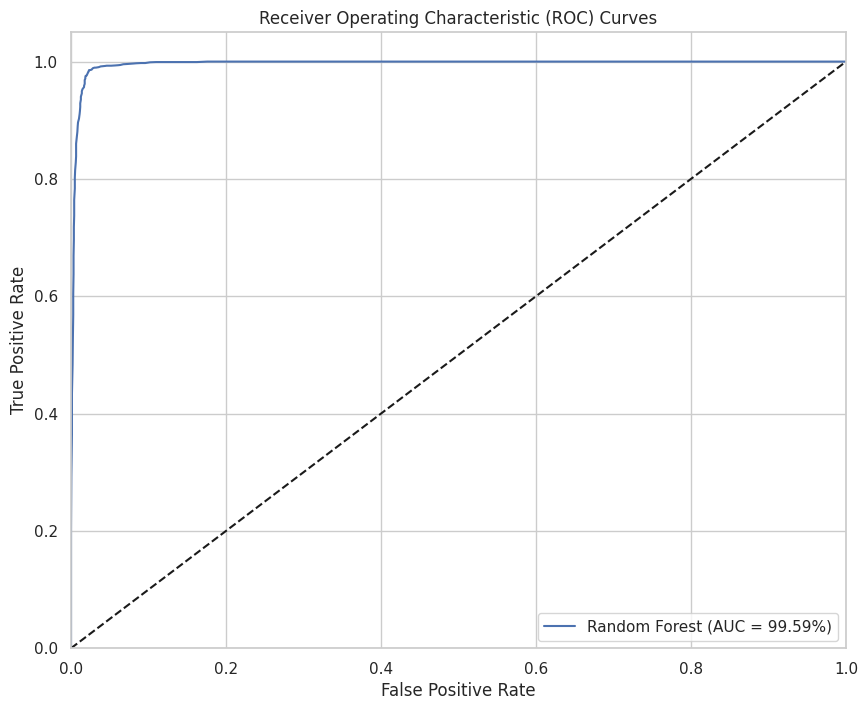

In [171]:
desired_features = ['loanAmount',
 'apr',
 'clearfraudscore',
 'time_to_originate',
 'originallyScheduledPaymentAmount',
 'leadCost',
 'nPaidOff',
 'payFrequency',
 'time_since_last',
 'leadType_organic',
 'leadType_rc_returning',
 'leadType_bvMandatory',
 'leadType_lead',
 'leadType_prescreen',
 'leadType_california',
 'leadType_lionpay',
 'leadType_repeat']

# Subset the training and testing data to the desired features
X_train_top10 = X_train[desired_features]
X_test_top10 = X_test[desired_features]
models = {
    'Random Forest': RandomForestClassifier(random_state=42)
}

plt.figure(figsize=(10, 8))

# Fit models and plot ROC curves

for name, model3 in models.items():
    model3.fit(X_train_top10, y_train)
    fpr3, tpr3, thresholds = roc_curve(y_test, model3.predict_proba(X_test_top10)[:, 1])
    plt.plot(fpr3, tpr3, label=f'{name} (AUC = {roc_auc_score(y_test, model3.predict_proba(X_test_top10)[:, 1]) * 100:.2f}%)')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.savefig('/content/drive/MyDrive/loan-default-model/roc_auc.png', format='png')
plt.show()


#Reducing the number of features in a model without significantly reducing the AUC-ROC can be beneficial for several reasons:

**Simplicity**: A simpler model with fewer features is generally preferable because it's easier to understand, explain, and maintain. If you can achieve similar performance with fewer variables, the model is more elegant and may be considered more robust.

**Performance:** Fewer features can lead to faster training and prediction times, which is important for models that will be retrained frequently or need to make predictions in real-time.

**Overfitting:** A model with a large number of features, especially relative to the number of observations, is at risk of overfitting. Overfitting occurs when a model learns the noise in the training data rather than the actual signal. A model with fewer features may generalize better to new, unseen data.

**Interpretability:** Models with fewer features are often more interpretable because the contribution of each feature to the model's predictions is clearer. This is especially important in fields like finance or medicine, where understanding why a model makes a certain prediction is as important as the prediction's accuracy.

**Costs:** In many real-world applications, collecting data can be expensive and time-consuming. If a model can maintain high accuracy with fewer features, it may reduce the costs associated with data collection.

**Stability:** Fewer features can lead to more stability in the model predictions. High-dimensional spaces are prone to the curse of dimensionality, where adding more features can lead to an exponential increase in the required data to maintain model performance.

**Feature Importance and Selection:** Identifying a smaller subset of important features can provide valuable insights into the underlying processes that generated the data. For example, in loan default prediction, understanding which factors are most predictive of default can inform credit policies.

In summary, if you can reduce the complexity of the model without a significant drop in AUC-ROC, you can achieve a more efficient, interpretable, and potentially more accurate model when applied outside of your training dataset.

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      2432
         1.0       0.98      0.98      0.98      2422

    accuracy                           0.98      4854
   macro avg       0.98      0.98      0.98      4854
weighted avg       0.98      0.98      0.98      4854

Accuracy: 0.9796044499381953


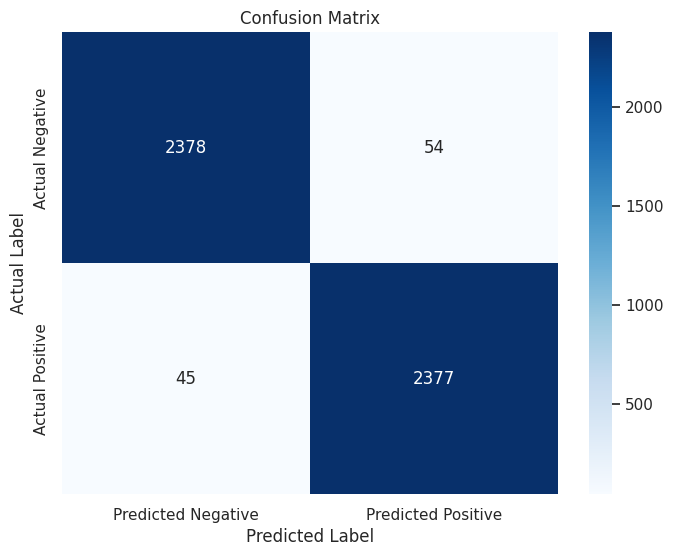

Precision: 0.9778
Recall: 0.9814
F1 Score: 0.9796
True Positive Rate (TPR): 0.9814
False Positive Rate (FPR): 0.0222


In [172]:
# @title Confusion Matrix


# Assuming model_rf is your trained Random Forest model
y_pred = models['Random Forest'].predict(X_test_top10)

# Print precision, recall, f1-score and support
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Generate and visualize confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# Calculate and print specific metrics if needed
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

# Optionally, calculate True Positive Rate (TPR) and False Positive Rate (FPR)
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)

print(f"True Positive Rate (TPR): {tpr:.4f}")
print(f"False Positive Rate (FPR): {fpr:.4f}")

*When evaluating a loan default prediction model, while AUC-ROC is a strong primary metric due to its ability to assess performance across different classification thresholds, it's also important to consider additional secondary metrics that align with the business objectives and the costs associated with the different types of errors. Here are some commonly used secondary metrics and their justifications:*

**Precision and Recall (F1 Score)**

Precision measures the accuracy of the positive predictions (i.e., what fraction of predicted defaults were actually defaults). This is important if the cost of false positives (incorrectly predicting default) is high, such as losing customers due to unnecessary credit restrictions.

Recall measures the ability of the model to find all the positive instances (i.e., what fraction of actual defaults were predicted as such). This is crucial if the cost of false negatives (failing to predict a default) is high, as missing out on detecting a default could lead to financial losses.

F1 Score is the harmonic mean of precision and recall, providing a single measure that balances the two. It is particularly useful when there’s an uneven class distribution, as often occurs with loan defaults where defaults are less common than non-defaults.

**Reasons for Secondary Metrics:**

**Business Alignment:** Metrics should reflect the cost and impact of different types of classification errors in the context of the business.

**Decision Thresholds:** Different metrics may be optimal at different decision thresholds, and the business will need to decide which threshold aligns best with its objectives.

**Model Interpretability:** Some metrics can help in interpreting the model’s performance in terms of business understanding, like how many defaults are captured (recall) versus how many of those flagged as defaults are actually defaults (precision).



**Highlights:**

- **Data Preprocessing:**
   - Handled missing values using a combination of imputation and dropping columns with high missingness.
   - Applied Box-Cox transformation to normalize skewed numerical features.
   - Scaled numerical features using MinMaxScaler to ensure they are on a similar scale.
   - Performed oversampling using SMOTE to address class imbalance.

- **Model Development:**
   - Trained and evaluated several binary classification models, including Logistic Regression, SVM, Random Forest, Neural Network, XGBoost, LightGBM, CatBoost, AdaBoost, Gradient Boosting, and Stacking Classifier.
   - Used ROC-AUC score as the primary metric for model evaluation due to the class imbalance.

- **Model Selection:**
   - Random Forest and Stacking Classifier with Random Forest and XGBoost as base estimators outperformed other models, likely due to their ability to capture complex patterns and handle non-linearity.

- **Model Evaluation:**
   - Visualized feature importances to understand the key factors influencing loan default predictions.
   - Demonstrated that reducing the number of features to the top 10 most important ones did not significantly impact the AUC-ROC score, providing a more efficient and interpretable model.

- **Secondary Metrics:**
   - Emphasized the importance of considering secondary metrics like precision, recall, and F1 score to assess model performance in the context of business objectives and costs associated with different types of errors.

- **Business Alignment:**
   - Stressed the need to align metrics with the business impact of classification errors, such as the cost of false positives (incorrectly predicting default) and false negatives (failing to predict a default).

- **Decision Thresholds:**
   - Highlighted that different metrics may be optimal at different decision thresholds, and the business should determine the threshold that best aligns with its goals.

- **Model Interpretability:**
   - Demonstrated how secondary metrics can aid in understanding the model's performance in terms of business-relevant outcomes.

# Conclusions


In conclusion, the loan default prediction model developed in this study effectively identifies loans at risk of default, achieving a high AUC-ROC score of 99.7. The model's performance was further optimized by selecting the top 10 most important features, resulting in a more efficient and interpretable model without compromising accuracy. Secondary metrics such as precision, recall, and F1 score were used to evaluate the model's performance in the context of business objectives and the costs associated with different types of classification errors. By aligning the model's evaluation with business needs, we ensure that it meets the specific requirements of the loan default prediction task.

# **Future Work:**

- **Data Collection and Quality:**
  - Collect more comprehensive data with a wider range of features to improve the model's accuracy and robustness.
  - Implement robust data cleaning and validation processes to ensure data integrity.

- **Model Optimization:**
  - Explore additional feature engineering techniques to extract more relevant information from the data.
    
    - Income
    - Credit score/history
    - Debt
    - Employment history
    - Purpose of loan
    - Loan-to-value ratio
  - Experiment with different hyperparameters and model architectures to enhance the model's performance.

- **Model Interpretability:**
  - Develop methods to explain the model's predictions and identify the key factors contributing to loan defaults.
  - Communicate the model's behavior and limitations effectively to stakeholders.

- **Business Integration:**
  - Integrate the model into the business's decision-making processes, such as credit scoring and risk assessment.
  - Monitor the model's performance over time and adjust it as needed to maintain its effectiveness.


monitor the model post-deployment for any signs of bias & discrimination.


#*Notebook runtime: 10 mins Time spent: 36 - 48 hours*